# Gaussian Based Flow: Solving 1D Schrödinger Equation Made Easy.

## Motivation

In this notebook we aim to introduce a powerful variational framework,which enables Variational Monte Carlo(VMC) calculation on Gaussian-based, normalizingly-flowed wavefunctions. Calculations for the ground state and excited states are performed on a 1-dimensional quantum system as a minimum demonstration.

## System

### Hamiltonian

Consider Hamiltonian

$$
  \hat H = -\frac{1}{2} \nabla^2 + \hat V
$$

with the following potential

$$
V(x) = 3x^4 + \frac{1}{2} x^3 - 3x^2
$$

Where $x$ is the one-dimensional coordinate of the particle.

Plotting the potential:

- First initialize discrete mesh

In [2]:
import sys
sys.path.append("../")
import numpy as np 
import matplotlib.pyplot as plt

# energy conversion factor
hartree2ev = 27.2107

xmin = -10; xmax = 10; Nmesh = 2000
xmesh = np.linspace(xmin, xmax, Nmesh)
h = xmesh[1] - xmesh[0]

- Then define the potential and plot it

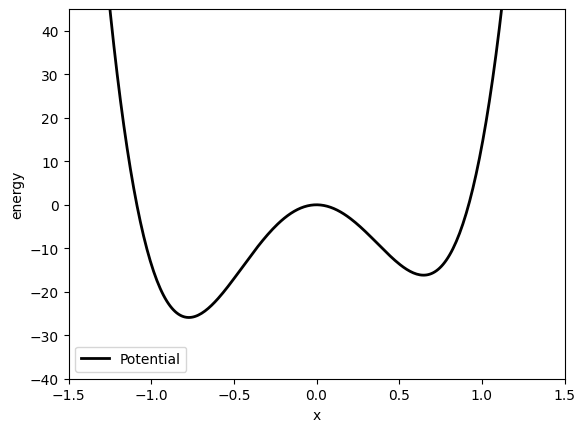

In [3]:
def Vpot(x):
    return 3*x**4 + x**3/2 - 3*x**2

plt.plot(xmesh, [Vpot(x)*hartree2ev for x in xmesh], 'k-', lw=2, label="Potential")
plt.xlabel("x")
plt.ylabel("energy")
plt.xlim([-1.5,1.5])
plt.ylim([-40,45])
plt.legend()
plt.show()

> The potential is quite anharmonic!

### Exact Results

By finite differential, we can construct the Hamiltonian on discrete meshes and then exact diagonalize it to get the exact wavefunctions and energy levels.

#### Ground State

First let's inspect the ground state probability density $\rho(x) = |\psi(x)|^2$ and the ground state energy:

Ground State Probability Density


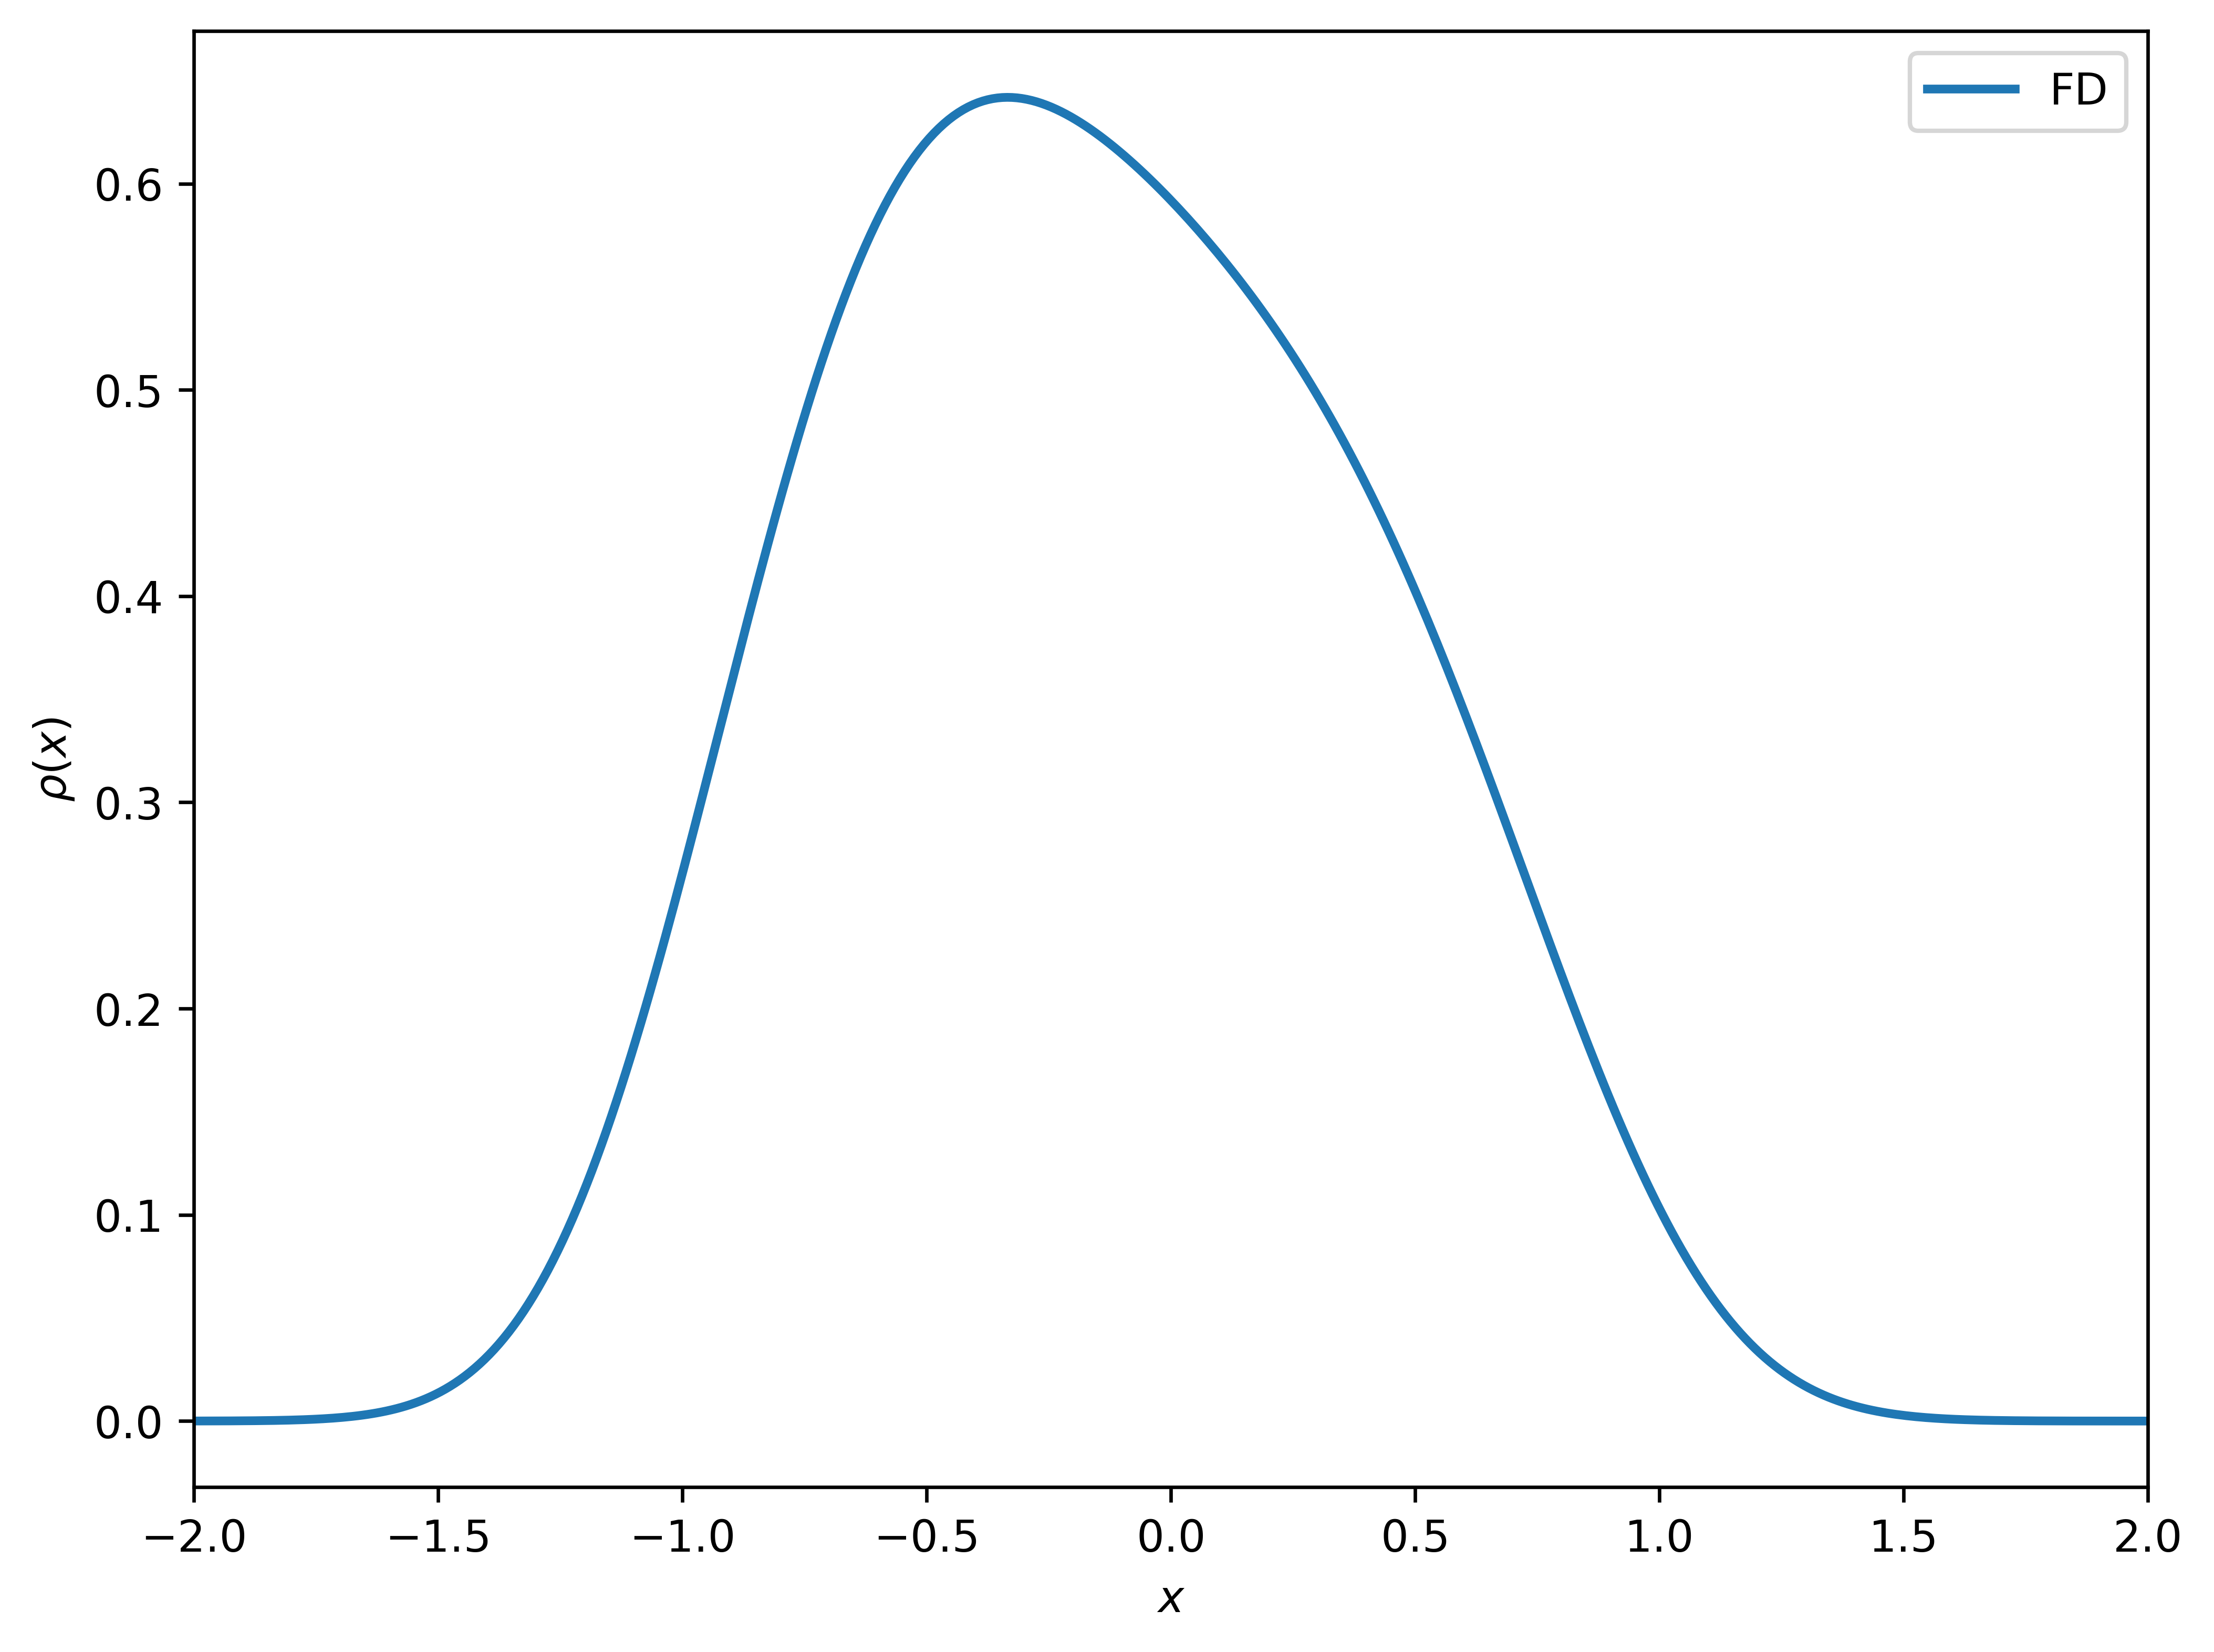

Ground State Energy:0.19457


In [4]:
from scipy.linalg import eigh 
from VMC.utils import buildH

# Finite Differential Method
# which would be <exact> if our mesh intervals are small enough
H = buildH(Vpot,xmesh,Nmesh,h)
w, v = eigh(H)

# ground state wave function
gs_wf = v[:,0]
normalize_factor = (gs_wf**2).sum() * h
# probability density
exact_gs_rho = gs_wf**2 / normalize_factor
    
print("Ground State Probability Density")
plt.plot(xmesh, exact_gs_rho, label='FD', lw=2)
plt.xlim([-2,2])
plt.xlabel('$x$')
plt.ylabel(r'$\rho(x)$')
plt.legend()
plt.show()

print(f"Ground State Energy:{w[0]:.5f}")

#### Excited State

5 lowest energy levels

In [5]:
num_of_orbs = 5
print(f"Lowest {num_of_orbs} Energies:")
print(f"{w[:num_of_orbs:]}")

Lowest 5 Energies:
[ 0.19456813  1.73513997  4.54932271  7.82492991 11.54729191]


## Variational Calculation

Let's move on to our variational calculation!

### Variational Principle

Consider a time-independent Hamiltonian $\hat H$ and a normalized state $\psi$, we have

- The energy expectation:

    > NOTE: here $d\tau$ is the (general) integral element

$$
E=\int\psi^{*} \hat{H} \psi d \tau
$$

- Normalization:

$$
\int\psi^{*} \psi d \tau=1
$$

- Then we make an arbitrary infinitesimal variance to the wavefunction (a variation to wavefunction):

$$
\psi\to\phi=\psi+\delta\psi
$$

- Then we calculate the energy expectation of the newly get state $\phi$, denoting as $E + \delta E$:

$$
E+\delta E=\frac{\int\phi^{*} \hat{H} \phi d \tau} {\int\phi^{*} \phi d \tau} 
$$

- Substituting the expression of $\phi$ into the formula above, omitting higer order terms and with some deductions, we have:

$$
\delta E=\int( \delta\psi^{*} \hat{H} \psi+\psi^{*} \hat{H} \delta\psi) d \tau-E \int( \delta\psi^{*} \psi+\psi^{*} \delta\psi) d \tau
$$

- Since $\delta \psi$ is arbitrary, we have the following deductions:
  - If   $\psi$ satisfies $\hat H \psi = E \psi$, then $\delta E = 0$
  - If   $(\delta E = 0 , \forall \delta \psi)$, then $\psi$ must satisfies $\hat H \psi = E \psi$
- Which is exactly the **Variational Principle**:

  > The expectation of $\hat H$ takes variational extremum $(\delta E = 0)$ $\Leftrightarrow$ $\psi$ is the eigenvector of $\hat H$


### Variational Method

- Suppose all the eigenvalues of the Hamiltonian are (in ascending order):

$$
E_0, \quad E_1, \quad E_2, \quad \ldots
$$

- with corresponding eigenvectors:

$$
\psi_0, \quad \psi_1, \quad \psi_2, \quad \ldots
$$

- with $E_0$ and $\psi_0$ the ground state energy and ground state wavefunction.

- Suppose the eigenvectors ${\psi_n}$ we have is already the complete basis of the Hilbert space, then any wavefunction $\phi$ in this Hilbert space could be expanded w.r.t. ${\psi_n}$:

$$
\phi=\sum_{n} c_{n} \psi_{n}, \qquad\sum_{n} | c_{n} |^{2}=1. 
$$

- The energy expectation has the form:

$$
\langle\phi| \hat{H} | \phi\rangle=\int\phi^{*} \hat{H} \phi d \tau=\sum_{m n} c_{m}^{*} c_{n} \int\psi_{m}^{*} \hat{H} \psi_{n} d \tau=\sum_{n} | c_{n} |^{2} E_{n}. 
$$

- Since $E_0$ is the ground state energy, we have

$$
\langle\phi| \hat{H} | \phi\rangle=\sum_{n} | c_{n} |^{2} E_{n} \geq E_{0}. 
$$

- If and only if $\phi = \psi_0$, aka, $\phi$ is exactly the ground state wavefunction, we have $\langle\phi| \hat{H} | \phi\rangle= E_{0}$.
- In other cases, the energy expectation of $\phi$ would be strictly greater than ground state energy.
- Base on this, we can prepare several trial wavefunctions $\phi_i$, calculate their energy expectations, and select the one $\phi_k$ with the smallest energy $E_k$. The selected $E_k$ has the closest value compared to exact ground state energy $E_0$ amongst all trial wavefunctions and $\phi_k$ is closest to exact ground state wavefunciton $\psi_0$ amongst $\phi_i$.

> However, `randomly` picking a wavefunction from the Hilbert space and praying it to be the ground state may seems idealistic. 
>
> How can we `systematically` determine the wavefunction that holds the variational extremum of the energy expectation?


> The answer is quite straingforward: **to introduce a** `variational parameter` **to the wavefunction**.

#### Variational Calculation Framework

- First, construct a wavefunction **with variational parameter** $\lambda$: $\phi(\lambda)$
  - Note that $\phi(\lambda)$ is also called a **wavefunction ansatz**.
- Then calculate the energy expectation of the trial wavefunction:

$$
  E(\lambda) = \langle\phi(\lambda)| \hat{H} | \phi(\lambda)\rangle
$$

- From the equation above, we have an energy expectation as a function of the variational parameter $\lambda$.
- Then we reach the extremum of the energy expection by making derivative w.r.t. $\lambda$

$$
    \frac{dE(\lambda)}{d\lambda} \bigg|_{\lambda_0} = 0
$$

- And getting the $\lambda_0$ that satisfies the formula above, we have $E(\lambda_0)$ as the best approximation of ground  state energy $E_0$ and $\phi(\lambda_0)$

##### Excited States

- Variational method could also be applied to excited states calculation.
- Suppose we have already variationally settled all the states whose energies are smaller than $E_n$: the wavefunctions $(\phi_0,\phi_1,\ldots,\phi_{n-1})$, then we can make induction to find variational solution to n-th excitated state $\phi_n$.
  - The constraint on our initial guess on $\phi_n$ should be: let $\phi_n$ **orthogonal to all the previous wavefunctions** $(\phi_0,\phi_1,\ldots,\phi_{n-1})$, we have

$$
  \psi( \lambda)=c_{n} \psi_{n}+c_{n+1} \psi_{n+1}+\cdots, 
$$

$$
  E ( \lambda)=c_{n}^{*} c_{n} E_{n}+c_{n+1}^{*} c_{n+1} E_{n+1}+\cdots\geq E_{n}. 
$$

- Then applying the derivative method again, we have the best approximation to n-th excited state:

$$
  \phi_n(\lambda_0),\quad E_n(\lambda_0)
$$

> The following part of this notebook is organized as
>
> - Gaussian Flowed Trial Wavefunctions
>   - The wavefunction ansatz utilizing normalizing flow, enables a straightforward excited states estimation.
> - Energy Estimator by MCMC
>   - Using Metropolis-Hastings algorithm to estimate the local energy.
> - Optimization of the Variational Parameter
>   - Utilizing AD to perform a gradient descent to find the best wavefunction.
>
> Which is in exactly the same order as we proposed in the Variational Calculation Framework part:
>
> - Trial Wavefunction $\phi(\lambda)$
> - Energy Expectation $E(\lambda)$
> - Finding Extremum $ \frac{dE(\lambda)}{d\lambda} \bigg|_{\lambda_0} = 0$


### Gaussian Flowed Trial Wavefunction

To parameterize the trial wavefunction, typically one would directly introduce a variational parameter into wavefunction, for example a simple [four-parameter helium wavefunction](https://opencommons.uconn.edu/chem_educ/30/) :

$$
 \phi_{He}(\vec r_1, \vec r_2; \theta:=\{a, b, c, d\}) = e^{-2s}(1+\frac{u}{2}e^{au})(1 + bsu + ct^2 + du^2) 
$$

where $s=r_1 + r_2$, $u=r_1 - r_2$, and $t=|\vec r_1 - \vec r_2|$ and $\theta$ is the variational parameter.

Despite of directly constructing trial wavefunction like this, we can also implement the trial wavefunction with parameter $\theta$:

$$
\Psi(x;\theta) = \Phi(f_\theta(x))\left| \text{det}\left(\frac{\partial f_\theta(x)}{\partial x}\right) \right|^{\frac{1}{2}}
$$

where $f_\theta$ is a bijective neural network (NN) with parameter $\theta$ that mapping the original coordinate $x \rightarrow z = f_\theta(x)$, $\Phi$ the initial basis we choose and $|\text{det}(\partial f_\theta(x)/\partial x)|^{1/2}$ the Jacobian determinant of the mapping $f_\theta(x)$ w.r.t. $x$.

By this kind of implementation, we are actually constructing a `normalizing flow` between two probability densities. For reference of normalizing flow, see [Normalizing Flows for Probabilistic Modeling and Inference](https://arxiv.org/abs/1912.02762v2). A concise illustration would be(from [Neural canonical transformations for vibrational spectra of molecules](https://pubs.aip.org/aip/jcp/article/161/2/024103/3302449/Neural-canonical-transformations-for-vibrational)):

![Normalizing Flow Wavefunction](./assets/Screenshot%202024-07-12%20165759.png)

The initial basis $\Phi$ are chosen as the eigenstates of a one-dimensional harmonic oscillator:

$$
\Phi_{n} ( \xi ) =  N_n \operatorname{e x p} \left(-\frac{1} {2} \xi^{2} \right) H_{n} \bigl(\xi \bigr)
$$

Where $n$ refers to the energy level quantum number of the state, and $H_n$ the n-th order Hermite polynomial. $\xi = \sqrt{m\omega/\hbar}z$ and $N_n$ the normalizing factor.

Then we can construct an assembly of **orthogonal** wavefunctions

$$
\Phi_0,\quad \Phi_1, \quad \ldots
$$

Since they are the eigenvectors of one-dimensional harmonic oscillators.

The **orthogonality is perserved throughout the flow transformation since the flow is an unitary transformation** ([m* of two-dimensional electron gas: A neural canonical transformation study](https://scipost.org/10.21468/SciPostPhys.14.6.154))

Then we get the wavefunctions of different energy levels that are orthogonal to each other as we expected:

$$
\Psi_0(x;\theta),\Psi_1(x;\theta),\Psi_2(x;\theta),\ldots
$$


The code below implement a simple residual-connected `MLP` flow using [Flax](https://flax.readthedocs.io/en/latest/) and define the wavefunction ansatz as stated above:

In [6]:
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as flax_nn

jax.config.update("jax_enable_x64", True)

@partial(jax.custom_jvp, nondiff_argnums=(0,))
def hermite(n: int, x: float) -> jax.Array:
    """The hermite polynominals"""
    h0 = 1.0 / jnp.pi ** (1 / 4)
    h1 = jnp.sqrt(2.0) * x / jnp.pi ** (1 / 4)

    def body_fun(i, val):
        valm2, valm1 = val
        return valm1, jnp.sqrt(2.0 / i) * x * valm1 - jnp.sqrt((i - 1) / i) * valm2

    _, hn = jax.lax.fori_loop(2, n + 1, body_fun, (h0, h1))

    return jax.lax.cond(n > 0, lambda: hn, lambda: h0)


@hermite.defjvp
def hermite_jvp(n:int, primals, tangents):
    (x,) = primals
    (dx,) = tangents
    hn = hermite(n, x)
    dhn = jnp.sqrt(2 * n) * hermite((n - 1) * (n > 0), x) * dx
    primals_out, tangents_out = hn, dhn
    return primals_out, tangents_out


def wf_base(
    x: float | jax.Array,
    n: int,
) -> jax.Array:
    """The wave function ansatz (Gaussian)
    NOTE: 1D!

    Args:
        x: the 1D coordinate of the (single) particle.
        n: the excitation quantum number

        NOTE: n=0 for GS!

    Returns:
        psi: the probability amplitude at x.
    """
    psi = jnp.exp(-0.5 * (x**2)) * hermite(n, x)
    return psi


class WFAnsatz:
    """The flow wave function ansatz"""

    def __init__(
        self,
        flow: flax_nn.Module,
    ) -> None:
        self.flow = flow

    def wf_ansatz(
        self,
        params: jax.Array | np.ndarray | dict,
        x: float | jax.Array,
        n: int,
    ) -> jax.Array:
        """The flow transformed log wavefunction

        Args:
            params: the flow parameter
            x: the coordinate before flow
            n: the excitation quantum number

            NOTE: n=0 for GS!

        Returns:
            amplitude: the wavefunction
        """
        z = self.flow.apply(params, x)[0]
        phi = wf_base(z, n)

        def _flow_func(x):
            return self.flow.apply(params, x)[0]

        jac = jax.jacfwd(_flow_func)(x)
        jacdet = jnp.sqrt(jnp.abs(jac))
        amplitude = phi * jacdet
        return amplitude

class MLPFlow(flax_nn.Module):
    """A simple MLP flow"""

    out_dims: int
    mlp_width: int
    mlp_depth: int

    @flax_nn.compact
    def __call__(self, x):
        for i in range(self.mlp_depth):
            _init_x = x
            x = x.reshape(
                1,
            )
            x = flax_nn.Dense(self.mlp_width)(x)
            x = flax_nn.sigmoid(x)
            x = flax_nn.Dense(self.mlp_width)(x)
            x = flax_nn.sigmoid(x)
            x = flax_nn.Dense(self.out_dims)(x)
            x = _init_x + x

        return x


Then we try to initialize the flow and test the initialized Jacobian determinant is close to identity as we expect.

> One of the important feature of the flow is that is should start from near identity transformation. To ensure this feature, we implement the residual network in the output layer so that the transformation would take the form of $z = f_\theta(x) = x + g_{\theta'}(x)$ where $g_{\theta'}$ denotes the network without the lase residual connection layer.
>
> This is quite like the backflow idea, and the near identity initialization is actually making the network learning the interactions from non-interacting states, mostly in an *adiabatic* manner.

And to test this feature we inspect the Jacobian after initialization of the network:

In [7]:
# Initialize flow
key = jax.random.PRNGKey(42)
model_flow = MLPFlow(out_dims=1,mlp_width=3,mlp_depth=5)
key, subkey = jax.random.split(key)
x_dummy = jnp.array(-1.0,dtype=jnp.float64)
key, subkey = jax.random.split(key)
params = model_flow.init(subkey, x_dummy)
# Initial Jacobian
init_jacobian = jax.jacfwd(lambda x: model_flow.apply(params, x))(x_dummy)
print(f"Init Jacobian = \n{init_jacobian}")



Init Jacobian = 
[1.03478089]


Visualization of the lowest 3 eigenvectors:

Wavefunction (Initialization)


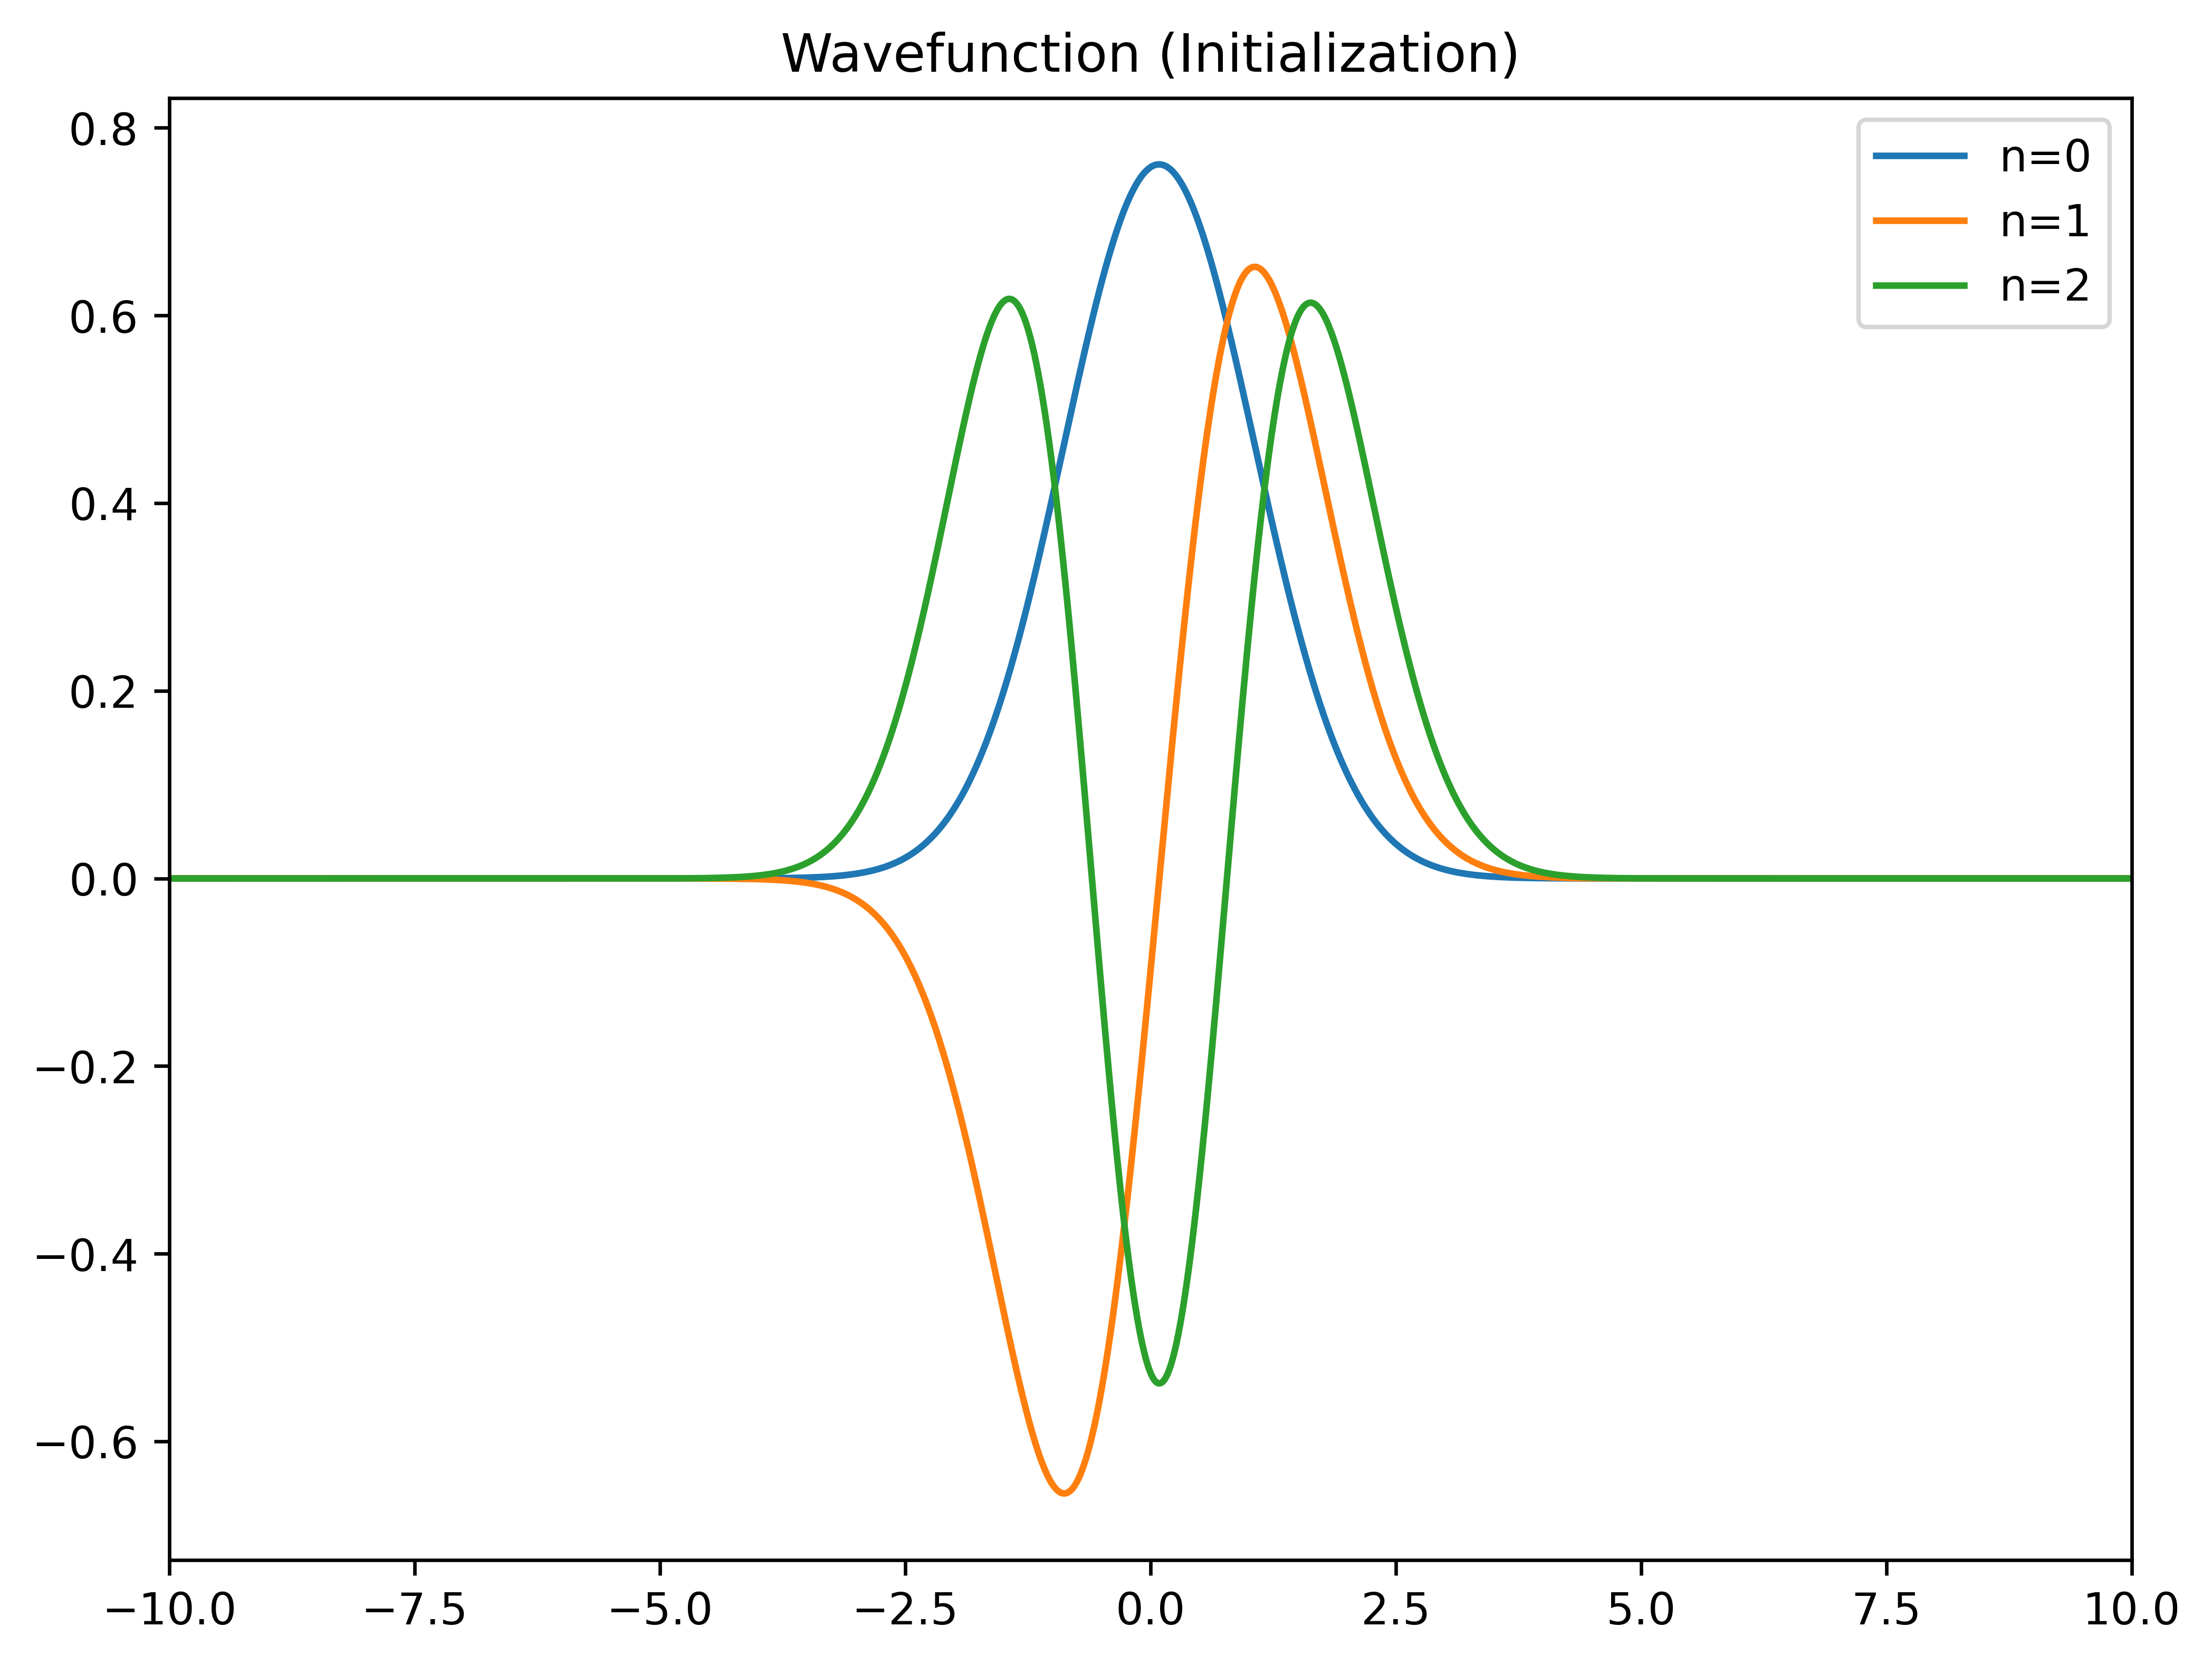

In [8]:
# The list containing the quantum number of eigenstates
state_indices = np.arange(3)
# Initialize Wavefunction
wf_ansatz_obj = WFAnsatz(flow=model_flow)
wf_ansatz = wf_ansatz_obj.wf_ansatz
wf_vmapped = jax.vmap(wf_ansatz, in_axes=(None, 0, 0))

# Plotting wavefunction
print("Wavefunction (Initialization)")
xmin = -10
xmax = 10
Nmesh = 2000
xmesh = np.linspace(xmin, xmax, Nmesh,dtype=np.float64)
mesh_interval = xmesh[1] - xmesh[0]
plt.figure()
for i in state_indices:
    wf_on_mesh = jax.vmap(wf_ansatz, in_axes=(None, 0, None))(params, xmesh, i)
    plt.plot(xmesh, wf_on_mesh, label=f"n={i}")
plt.xlim([-10, 10])
plt.legend()
plt.title("Wavefunction (Initialization)")
plt.show()
plt.close()

### Energy Estimator by MCMC

In order to calculate the energy expectation of the given trial wavefunction, we need:
1. An energy estimator that estimate the local energy of a given wavefunction at position x:

$$
E_L(x;\theta) = \frac{\hat H \Psi(x;\theta)}{\Psi(x;\theta)}
$$

2. An efficient algorithm to estimate the energy expectation:

$$
  \langle E\rangle_\theta
  = \frac{\int \mathrm d x \, \Psi^*(x; \theta)\hat H \Psi(x; \theta) } {\int
  \mathrm d x \,|\Psi(x; \theta)|^2}
$$

First let's make a straightforward implementation of the local energy estimator:

In [9]:
class EnergyEstimator:
    """Energy Estimator"""

    def __init__(self, wf_ansatz: callable) -> None:
        self.wf_ansatz = wf_ansatz

    def local_kinetic_energy(
        self,
        params: jax.Array | np.ndarray | dict,
        xs: jax.Array,
        state_indices: np.ndarray,
    ) -> jax.Array:
        """Local Kinetic Energy Estimator
        NOTE: per batch implementation.

        Args:
            params: the flow parameter
            xs: (num_of_orbs,) the 1D coordinate of the particle(s).
                The xs are in corresponding order as in state_indices.
            state_indices: (num_of_orbs,) the array containing
                the excitations in each bath, for example,
                [0,1,2] represents there are totally 3 number
                of orbitals: ground state: 0
                            first excitation state: 1
                            second excitation state: 2

        Returns:
            local_kinetic: the local kinetic energy.
        """
        single_laplacian_func = jax.grad(jax.grad(self.wf_ansatz, argnums=1), argnums=1)
        wf_vmapped = jax.vmap(self.wf_ansatz, in_axes=(None, 0, 0))
        laplacians = jax.vmap(single_laplacian_func, in_axes=(None, 0, 0))(
            params, xs, state_indices
        )
        local_kinetics = -0.5 * laplacians / wf_vmapped(params, xs, state_indices)
        return local_kinetics

    @staticmethod
    def local_potential_energy(
        xs: jax.Array,
    ) -> jax.Array:
        """Local Potential Energy Estimator

        Args:
            xs: (num_of_orbs,) the 1D coordinate of the particle(s).
                The xs are in corresponding order as in state_indices.
        Returns:
            local_potential: the local potential energy.
        """
        local_potentials = 3 * xs**4 + xs**3 / 2 - 3 * xs**2
        return local_potentials

    def local_energy(
        self,
        params: jax.Array | np.ndarray | dict,
        xs: jax.Array,
        state_indices: np.ndarray,
    ) -> jax.Array:
        """Local Energy Estimator

        Args:
            params: the flow parameter
            xs: (num_of_orbs,) the 1D coordinate of the particle(s).
                The xs are in corresponding order as in state_indices.
            state_indices: (num_of_orbs,) the array containing
                the excitations in each bath, for example,
                [0,1,2] represents there are totally 3 number
                of orbitals: ground state: 0
                            first excitation state: 1
                            second excitation state: 2

        Returns:
            local_energy: the local energy.
        """
        kin_energy = self.local_kinetic_energy(params, xs, state_indices)
        pot_energy = self.local_potential_energy(xs)
        local_energy = kin_energy + pot_energy
        return local_energy

Then let's randomly draw a sample between (-1.5,1.5) and estimate it's local energy w.r.t. the randomly initialized wavefunction:

In [10]:
# Local Energy Estimator
energy_estimator = EnergyEstimator(wf_ansatz=wf_ansatz)
x_test_local_energy = np.random.uniform(-1.5, 1.5, state_indices.shape)
x_test_local_energy = jnp.array(x_test_local_energy)
local_energy = energy_estimator.local_energy(
    params, x_test_local_energy, state_indices
)
print("Testing Local Energy Estimator:")
print(
    f"testing x: {x_test_local_energy}\n"
    f"state_indices: {state_indices}\n"
    f"Get local energy = {local_energy}"
)

Testing Local Energy Estimator:
testing x: [-0.03994224 -1.0192558  -0.8690159 ]
state_indices: [0 1 2]
Get local energy = [0.50929114 0.50371338 1.27895819]


Now we have the local energy estimator, let's try to substitude the local energy expression into the expectation formula. We get the importance sampling algorithm that estimate the energy expectation efficiently:

$$
\begin{align*}
  \langle E\rangle_\theta
  &= \frac{\int \mathrm d x\, \Psi^*(x; \theta)\hat H \Psi(x; \theta) } {\int
  \mathrm d x\,|\Psi(x; \theta)|^2} \\
  &= \int \mathrm d x\, p(x; \theta) E_L(x; \theta) \\
  &\approx \underset{x \sim p(x;\theta)} {\mathbb{E}} \left[ E_{L} ( x ) \right] 
  \\&\approx
   \frac{1}{M} \sum_i^M E_L(x^{(i)}; \theta).
\end{align*}
$$

This converts the energy expectation from the high dimensional integration into a Markov Chain Monte Carlo(MCMC) sampling problem, which significantly reduces the computational resources we need to estimate the expectations.

The integral is approximated by drawing $M$ configurations $\left\{x^{(i)}\right\}$ that are sampled from the probability distribution defined by wavefunction:

$$
  p_\theta(x^{(i)})
  = \frac{|\Psi(x^{(i)}; \theta)|^2 }{ \int \mathrm d x\,|\Psi(x; \theta)|^2}
$$

And then take statistical average over these values.

An efficient way to sample according to $p(x;\theta)$ is the Metropolis-Hastings algorithm. It works by proposing moves $x'$ locally from a Gaussian distribution $N(x, \sigma)$ with mean $x$ and standard deviation $\sigma$. $\sigma$ is also called the step size. (The move proposal need not be Gaussian or even symmetric, but this choice works well for many cases.)

The probability of accepting a proposed move $x \to x'$ in the Metropolis algorithm (symmetric move proposal) is given by
$$
  p(x \to x') = \text{min}\left(1, \frac{p(x')}{p(x)}\right) = \text{min}\left(1, \frac{|\Psi(x')|^2}{|\Psi(x)|^2}\right)
$$

If the probability calculated from the wavefunction at the proposed configuration is larger than at the original position, then the proposal is always accepted. If not, then the acceptance is proportional to the ratio of the wavefunction. 
If you want more information on the Metropolis algorithm, please refer to [Wikipedia article](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

Observe that the wavefunction doesn't have to be normalized, since the normalization factor cancels out in the ratio. This is extremely useful!

Here is another illustration helping to understand the difference between Metropolis method with conventional quadrature scheme: (from [Understanding Molecular Simulation](https://www.sciencedirect.com/book/9780122673511/understanding-molecular-simulation))

![Comparasion of convention quadrature and Metropolis](./assets/Screenshot%202024-07-12%20220905.png)

> In this figure, we compare two ways of
 measuring the depth of the river Nile, by conventional quadrature (left) and
 byMetropolis sampling; that is, the construction of an importance-weighted
 random walk (right). In the conventional quadrature scheme, the value of
 the integrand is measured at a predetermined set of points. As the choice
 of these points does not depend on the value of the integrand, many points
 may be located in regions where the integrand vanishes. In contrast, in the
 Metropolis scheme, a random walk is constructed through that region of
 space where the integrand is nonnegligible (i.e., through the Nile itself). In
 this random walk, a trial move is rejected if it takes you out of the water and
 is accepted otherwise. After every trial move (accepted or not), the depth of
 the water is measured. The (unweighted) averageof all these measurements
 yields an estimate of the average depth of the Nile. This, then, is the essence
 of the Metropolis method.

A one-step metropolis as well as a mcmc core function that performs `steps` of configuration updates are implemented as follow:

In [11]:
class Metropolis:
    """The Metropolis Algorithm
    iterating the positions of MCMC walkers according
    to the Metropolis algorithm.
    """

    def __init__(self, wf_ansatz: callable) -> None:
        self.wf_ansatz = wf_ansatz

    def oneshot_sample(
        self,
        xs: jax.Array,
        state_indices: np.ndarray,
        probability: jax.Array,
        params: jax.Array | np.ndarray | dict,
        step_size: float,
        key: jax.random.PRNGKey,
    ) -> list[
        float | jax.Array,
        float,
        int,
    ]:
        """The one-step Metropolis update

        Args:
            xs: (num_of_orbs,) the 1D coordinate of the particle(s).
                The xs are in corresponding order as in state_indices.
            state_indices: (num_of_orbs,) the array containing
                the excitations in each bath, for example,
                [0,1,2] represents there are totally 3 number
                of orbitals: ground state: 0
                            first excitation state: 1
                            second excitation state: 2
            probability:(num_of_orbs,) the probability in current particle coordiante
                xs and
                with corresponding state_indices.
            params: the flow parameter
            step_size: the step size of each sample step. e.g.
                x_new = x + step_size * jax.random.normal(subkey, shape=pos.shape)
            key: the jax PRNG key.

        Returns:
            xs_new: the updated xs
            probability_new: the updated probability
            accetp_count: the number of updates performed per walker.
        """
        key, subkey = jax.random.split(key)
        wf_vmapped = jax.vmap(self.wf_ansatz, in_axes=(None, 0, 0))

        xs_new = xs + step_size * jax.random.normal(subkey, shape=xs.shape)
        probability_new = wf_vmapped(params, xs_new, state_indices) ** 2

        # Metropolis
        key, subkey = jax.random.split(key)
        cond = (
            jax.random.uniform(subkey, shape=probability.shape)
            < probability_new / probability
        )
        probability_new = jnp.where(cond, probability_new, probability)
        xs_new = jnp.where(cond, xs_new, xs)

        # Count accepted proposals
        accept_count = jnp.sum(cond)

        return xs_new, probability_new, accept_count


def mcmc(
    steps: int,
    num_substeps: int,
    metropolis_sampler_batched: callable,
    key: jax.random.PRNGKey,
    xs_batched: jax.Array,
    state_indices: np.ndarray,
    params: dict,
    probability_batched: jax.Array,
    mc_step_size: float,
    pmove: float,
) -> list[jax.random.PRNGKey, jax.Array, jax.Array, float, float]:
    """The batched mcmc function for #steps sampling.
    NOTE: this is a jax foriloop implementation

    Args:
        steps: the steps to perform
        num_substeps: the mcmc substep number.
        metropolis_sampler_batched: the batched metropolis sampler.
        key: the jax.PRNGkey
        xs_batched: (num_of_batch,num_of_orbs,) the batched 1D coordinate
            of the particle(s).
            The xs are in corresponding order as in state_indices.
        state_indices: (num_of_orbs,)the array containing
            the excitations in each bath, for example,
            [0,1,2] represents there are totally 3 number
            of orbitals: ground state: 0
                        first excitation state: 1
                        second excitation state: 2
        params: the parameters of network
        probability_batched: (num_of_batch,num_of_orbs,)
            the batched probability for each state (wavefunction**2)
        mc_step_size: last mcmc moving step size.
        pmove: the portion of moved particles in last mcmc step.

    Returns:
        key: the jax.PRNGkey
        xs_batched: (num_of_batch,num_of_orbs,) the batched 1D
            coordinate of the particle(s).
            The xs are in corresponding order as in state_indices.
        probability_batched: (num_of_batch,num_of_orbs,)
            the batched probability for each state (wavefunction**2)
        mc_step_size: updated mcmc moving step size.
        pmove: the portion of moved particles in current mcmc step.
    """

    @jax.jit
    def _body_func(i, val):
        """MCMC Body function"""
        key, xs_batched, probability_batched, mc_step_size, pmove = val
        batch_size = xs_batched.shape[0]
        key, batch_keys = key_batch_split(key, batch_size)
        xs_batched, probability_batched, accept_count = metropolis_sampler_batched(
            xs_batched,
            state_indices,
            probability_batched,
            params,
            mc_step_size,
            batch_keys,
        )
        pmove = np.sum(accept_count) / (
            num_substeps * batch_size * state_indices.shape[0]
        )
        mc_step_size = jnp.where(
            pmove > 0.5,
            mc_step_size * 1.1,
            mc_step_size * 0.9,
        )
        return key, xs_batched, probability_batched, mc_step_size, pmove

    mcmc_init_val = (key, xs_batched, probability_batched, mc_step_size, 0)
    key, xs_batched, probability_batched, mc_step_size, pmove = jax.lax.fori_loop(
        0, steps, _body_func, mcmc_init_val
    )
    return key, xs_batched, probability_batched, mc_step_size, pmove

Then we initialize `batch_size` walkers, performs `thermal_step` mcmc to thermalize the system, and inspect the acceptance rate after thermalization:

Hint: whilst not critical in this case, a good rule of thumb is to aim for an acceptance rate of around 50%.

In [12]:
def init_batched_x(
    key: jax.random.PRNGKey,
    batch_size: int,
    num_of_orbs: int,
    init_width: float = 1.0,
) -> jax.Array:
    """Init batched x

    Args:
        key: the jax PRNG key
        batch_size: the number of walkers to creat.
        num_of_orbs: the total number of orbitals.
        init_width: scale of initial Gaussian distribution

    Returns:
        init_x: (batch_size,) the initialized (batched) x.
    """
    init_x = init_width * jax.random.normal(key, shape=(batch_size, num_of_orbs),dtype=jnp.float64)
    return init_x

def key_batch_split(key: jax.random.PRNGKey, batch_size: int):
    """Like jax.random.split, but returns one subkey per batch element.

    Args:
        key: jax.PRNGkey
        batch_size: the batch size.

    Returns:
        key: jax.PRNGkey, shape (2,)
        batch_keys: jax.PRNGkeys, shape (batch_size, 2)
    """
    key, *batch_keys = jax.random.split(key, num=batch_size + 1)
    return key, jnp.asarray(batch_keys)


In [13]:
import time

batch_size = 100
thermal_step = 20
init_width = 1.5
step_size = 1.5
num_substeps = 1 # DONT TOUCH!

# Metropolis, thermalization
key, subkey = jax.random.split(key)
init_x_batched = init_batched_x(
    key=subkey,
    batch_size=batch_size,
    num_of_orbs=state_indices.shape[0],
    init_width=init_width,
)
metropolis = Metropolis(wf_ansatz=wf_ansatz)
metropolis_sample = metropolis.oneshot_sample
metropolis_sample_batched = jax.jit(
    jax.vmap(metropolis_sample, in_axes=(0, None, 0, None, None, 0))
)
probability_batched = (
    jax.vmap(wf_vmapped, in_axes=(None, 0, None))(
        params, init_x_batched, state_indices
    )
    ** 2
)
xs = init_x_batched

print("Thermalization...")
pmove = 0
t0 = time.time()
key, xs, probability_batched, step_size, pmove = mcmc(
    steps=thermal_step,
    num_substeps=num_substeps,
    metropolis_sampler_batched=metropolis_sample_batched,
    key=key,
    xs_batched=xs,
    state_indices=state_indices,
    params=params,
    probability_batched=probability_batched,
    mc_step_size=step_size,
    pmove=pmove,
)
t1 = time.time()
time_cost = t1 - t0
print(
    f"After Thermalization:\tpmove {pmove:.2f}\t"
    f"step_size={step_size:.4f}\ttime={time_cost:.2f}s",
    flush=True,
)

Thermalization...
After Thermalization:	pmove 0.57	step_size=1.3566	time=3.80s


### Optimization of the Variational Parameter

Up to now we've already been able to calculate the energy expectation on our trail wavefunction!

Finally it comes to find the best variational parameter $\theta_0$ that minimizes the energy expectation $E(\theta)$.

With the advantages of AutoDifferentiate (AD) feature supported by Jax, the most straightforward way to find the variance minimum is to gradient descent through the paramter $\theta$.

We can efficiently compute the gradient of the energy using:

$$
\nabla_\theta\mathcal{L} = 2 \mathbb{E}_{p(x)}\left[\left(E_L - \mathbb{E}_{p(x)}[E_L]\right)\nabla_\theta \log|\Psi_\theta|\right]
$$

In particular, this means we don't have to compute derivatives of the Hamiltonian, and so do not require third derivatives of the wavefunction! Code for doing so (adapted from the [FermiNet codebase](https://github.com/deepmind/ferminet)) is below.

In [14]:
def make_loss(
    wf_ansatz: callable, local_energy_estimator: callable, state_indices: np.ndarray
):
    """Copied from Ferminet.

    Creates the loss function, including custom gradients.
    NOTE: batched implementation!

    Args:
    wf_ansatz: function, signature (params, x, n), which evaluates wavefunction
        at a single MCMC configuration given the network parameters.
    local_energy_estimator: signature (params, xs, state_indices), here
        xs refers to the x coordinates in one single batch, xs has shape (num_of_orb,)
    state_indices: (num_of_orbs,)the array containing
        the excitations in each bath, for example,
        [0,1,2] represents there are totally 3 number
        of orbitals: ground state: 0
                    first excitation state: 1
                    second excitation state: 2
    Returns:
        total_energy: function which evaluates the both the loss as the mean of the
        local_energies, and the local energies. With custom gradients, accounting
        for derivatives in the probability distribution.
    """
    batch_local_energy = jax.vmap(
        local_energy_estimator, in_axes=(None, 0, None), out_axes=0
    )
    # FermiNet is defined in terms of the logarithm of the network, which is
    # better for numerical stability and also makes some expressions neater.
    log_wf = lambda params, x, n: jnp.log(jnp.abs(wf_ansatz(params, x, n)))
    # vmapped wavefunction: signature (params, xs, state_indices)
    log_wf_vmapped = jax.vmap(log_wf, in_axes=(None, 0, 0))
    # batch_wf: signature (params, batched_xs, state_indices)
    batch_wf = jax.vmap(log_wf_vmapped, in_axes=(None, 0, None), out_axes=0)

    @jax.custom_jvp
    def total_energy(params, batched_xs) -> tuple[float, np.ndarray]:
        """Total energy of an ensemble (batched)

        Args:
            params: the network parameters
            batched_xs: (num_of_batch, num_of_orbs,)
                the batched 1D coordinate of the particle(s).
                The xs are in corresponding order as in state_indices.

        Returns:
            loss: the total loss of the system, meaned over batch.
            e_l: (batch,num_of_orbs,) the local energy of each state.
        """
        e_l = batch_local_energy(params, batched_xs, state_indices)
        loss = jnp.mean(jnp.sum(e_l, axis=-1))
        return loss, e_l

    @total_energy.defjvp
    def total_energy_jvp(primals, tangents):
        """Custom Jacobian-vector product for unbiased local energy gradients."""
        params, batched_xs = primals
        loss, local_energy = total_energy(params, batched_xs)
        diff = local_energy - loss

        def _batch_wf(params, batched_xs):
            return batch_wf(params, batched_xs, state_indices)

        psi_primal, psi_tangent = jax.jvp(_batch_wf, primals, tangents)
        primals_out = loss, local_energy
        tangents_out = (
            jnp.mean(2 * jnp.sum(psi_tangent * diff, axis=-1)),
            local_energy,
        )

        return primals_out, tangents_out

    return total_energy


Then we measure the energy expection of the system we just thermalized:

In [15]:
# Loss function
loss_energy = make_loss(
    wf_ansatz=wf_ansatz,
    local_energy_estimator=energy_estimator.local_energy,
    state_indices=state_indices,
)
loss_and_grad = jax.jit(
    jax.value_and_grad(loss_energy, argnums=0, has_aux=True)
)
(loss, energies), gradients = loss_and_grad(params, xs)
print(f"After MCMC, with initial network, loss={loss:.5f}")
print(f"State indices: {state_indices}")
print(f"Energies = {jnp.mean(energies,axis=0)}")


After MCMC, with initial network, loss=31.08776
State indices: [0 1 2]
Energies = [ 0.8060778   9.52399442 20.75769183]


With the gradients calculates, we can update the variational parameters to reduce the total energy expectation.

For small and simple systems, a simple first order optimization method such as ADAM is sufficient. The [`optax`](https://github.com/deepmind/optax) library provides many optimizers and useful utilities for optimization.

Other optimizers in `optax` share the same API: the `init` method initialises the optimizer and takes an arbitary structure (a "PyTree") of trainable parameters. This conveniently enables parameters to be organised as nested dictionaries, for example.

Now we seek for a one-step optimization using `optax`, and see if the loss after optimizaiton decreases:

In [16]:
import optax

init_learning_rate = 2e-2
# One Step Optimization
optimizer = optax.adam(init_learning_rate)
opt_state = optimizer.init(params)

updates, opt_state = optimizer.update(gradients, opt_state, params)
new_params = optax.apply_updates(params, updates)
(loss, energies), gradients = loss_and_grad(new_params, xs)
print(f"One step optimization with previous x, loss={loss:.5f}")
print(f"Energies = {jnp.mean(energies,axis=0)}")

One step optimization with previous x, loss=30.80885
Energies = [ 0.75330796  9.40765542 20.64788902]


> That's one small step for 'an' electron, one giant leap towards ground state

To reach for the variational minimum, we need to loop over the following training steps for each iteration:

1. runs Metropolis-Hastings to draw samples according to $\Psi^2$
2. evaluates the energy and gradients
3. updates the parameters

Tip: Remember to equilibrate the MCMC samples after initialising them from a Gaussian distribution, as well as between each parameter update!

The core training update function is implemented as:

In [17]:
class Update:
    """Update functions"""

    def __init__(
        self,
        mcmc_steps: int,
        state_indices: np.ndarray,
        batch_size: int,
        num_substeps: int,
        metropolis_sampler_batched: callable,
        loss_and_grad: callable,
        optimizer: optax.GradientTransformation,
        acc_steps: int,
    ) -> None:
        self.mcmc_steps = mcmc_steps
        self.state_indices = state_indices
        self.batch_size = batch_size
        self.num_substeps = num_substeps
        self.metropolis_sampler_batched = metropolis_sampler_batched
        self.loss_and_grad = loss_and_grad
        self.optimizer = optimizer
        self.acc_steps = acc_steps

    def update(
        self,
        key: jax.random.PRNGKey,
        xs_batched: jax.Array,
        probability_batched: jax.Array,
        mc_step_size: float,
        params: jax.Array | np.ndarray | dict,
        opt_state: optax.OptState,
    ) -> tuple[
        float, float, jax.Array, jax.Array, dict, optax.OptState, float, float
    ]:
        """Single update
        NOTE: call WITHOUT vmap!

        Args:
            key: the jax.PRNGkey
            xs_batched: (num_of_batch,num_of_orbs,) the batched 1D coordinate
                of the particle(s).
                The xs are in corresponding order as in state_indices.
            probability_batched: (num_of_batch,num_of_orbs,)
                the batched probability for each state (wavefunction**2)
            mc_step_size: the initial mcmc moving step size.
            params: the flow parameters
            opt_state: the optimizer state.

        Returns:
            loss: the meaned energy as loss
            energy_std: the energy standard deviation.
            xs_batched: the coordinate
            probability_batched: the batched probability (wavefunction**2)
            params: the flow parameters
            opt_state: the optimizer state.
            pmove: the portion of moved coordinates.
            mc_step_size: the mcmc moving step size.
        """

        def _mcmc_body_func(i, val):
            """MCMC Body function"""
            key, xs_batched, probability_batched, mc_step_size, pmove = val
            key, batch_keys = key_batch_split(key, self.batch_size)
            (
                xs_batched,
                probability_batched,
                accept_count,
            ) = self.metropolis_sampler_batched(
                xs_batched,
                self.state_indices,
                probability_batched,
                params,
                mc_step_size,
                batch_keys,
            )
            pmove = np.sum(accept_count) / (
                self.num_substeps * self.batch_size * self.state_indices.shape[0]
            )
            mc_step_size = jnp.where(
                pmove > 0.5,
                mc_step_size * 1.1,
                mc_step_size * 0.9,
            )
            return key, xs_batched, probability_batched, mc_step_size, pmove

        def _acc_body_func(i, val):
            """Gradient Accumulation Body Function"""
            (
                loss,
                energies,
                grad,
                key,
                xs_batched,
                probability_batched,
                mc_step_size,
                pmove,
                params,
            ) = val
            mcmc_init_val = (key, xs_batched, probability_batched, mc_step_size, 0)
            (
                key,
                xs_batched,
                probability_batched,
                mc_step_size,
                pmove,
            ) = jax.lax.fori_loop(0, self.mcmc_steps, _mcmc_body_func, mcmc_init_val)
            (loss, energies), gradients = self.loss_and_grad(params, xs_batched)
            grad = jax.tree.map(jnp.mean, gradients)
            return (
                loss,
                energies,
                grad,
                key,
                xs_batched,
                probability_batched,
                mc_step_size,
                pmove,
                params,
            )

        # Only for initialization of val in jax.lax.foriloop!
        (loss, energies), gradients = self.loss_and_grad(params, xs_batched)
        grad = jax.tree.map(jnp.mean, gradients)
        acc_init_val = (
            loss,
            energies,
            grad,
            key,
            xs_batched,
            probability_batched,
            mc_step_size,
            0,
            params,
        )

        (
            loss,
            energies,
            grad,
            key,
            xs_batched,
            probability_batched,
            mc_step_size,
            pmove,
            params,
        ) = jax.lax.fori_loop(0, self.acc_steps, _acc_body_func, acc_init_val)

        updates, opt_state = self.optimizer.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        energy_std = jnp.sqrt(
            ((jnp.sum(energies, axis=-1) ** 2).mean() - loss**2)
            / (self.acc_steps * self.batch_size)
        )
        return (
            loss,
            energy_std,
            xs_batched,
            probability_batched,
            params,
            opt_state,
            pmove,
            mc_step_size,
        )


### Ground State (Variational)

Scripts below performs a complete ground state variational calculation, with system parameters defined at the formost of the code:

In [18]:
import scipy
import tqdm.notebook as tqdm
# Plotting Settings
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 600

The training kernel

In [19]:
def training_kernel(args:dict, savefig:bool = True) -> None:
    """Training Kernel"""
    # Initialize flow
    key = args["key"]
    batch_size = args["batch_size"]
    total_num_of_states = args["total_num_of_states"]
    thermal_step = args["thermal_step"]
    acc_steps = args["acc_steps"]
    mc_steps = args["mc_steps"]
    step_size = args["step_size"]
    num_substeps = args["num_substeps"]
    init_width = args["init_width"]
    mlp_width = args["mlp_width"]
    mlp_depth = args["mlp_depth"]
    init_learning_rate = args["init_learning_rate"]
    iterations = args["iterations"]
    inference_batch_size = args["inference_batch_size"]
    inference_thermal_step = args["inference_thermal_step"]
    figure_save_path = args["figure_save_path"]

    num_of_excitation_orbs = total_num_of_states
    state_indices = np.arange(total_num_of_states)

    if total_num_of_states == 1:
        print("=======================GS=========================")
    else:
        print("======================================")
        print(f"First {num_of_excitation_orbs} Excitation States")
        print("======================================")

    if savefig:
        if not os.path.isdir(figure_save_path):
            print("Creating Directory")
            os.makedirs(figure_save_path)
        else:
            # raise FileExistsError("Desitination already exists! Please check!")
            pass

    model_flow = MLPFlow(out_dims=1,mlp_width=mlp_width,mlp_depth=mlp_depth)
    key, subkey = jax.random.split(key)
    x_dummy = jnp.array(-1.0, dtype=jnp.float64)
    key, subkey = jax.random.split(key)
    params = model_flow.init(subkey, x_dummy)
    # Initial Jacobian
    init_jacobian = jax.jacfwd(lambda x: model_flow.apply(params, x))(x_dummy)
    print(f"Init Jacobian = \n{init_jacobian}")

    # Initialize Wavefunction
    wf_ansatz_obj = WFAnsatz(flow=model_flow)
    wf_ansatz = wf_ansatz_obj.wf_ansatz
    wf_vmapped = jax.vmap(wf_ansatz, in_axes=(None, 0, 0))

    # Plotting wavefunction
    print("Wavefunction (Initialization)")
    xmin = -10
    xmax = 10
    Nmesh = 2000
    xmesh = np.linspace(xmin, xmax, Nmesh, dtype=np.float64)
    mesh_interval = xmesh[1] - xmesh[0]
    plt.figure()
    for i in state_indices:
        wf_on_mesh = jax.vmap(wf_ansatz, in_axes=(None, 0, None))(params, xmesh, i)
        plt.plot(xmesh, wf_on_mesh, label=f"n={i}")
    plt.xlim([-10, 10])
    plt.legend()
    plt.title("Wavefunction (Initialization)")
    if savefig:
        plt.savefig(
            f"{os.path.join(figure_save_path, "WavefunctionInitialization.png")}"
        )
        print("Figure Saved.")
    else:
        plt.show()
    plt.close()

    # Local Energy Estimator
    energy_estimator = EnergyEstimator(wf_ansatz=wf_ansatz)

    # Metropolis, thermalization
    key, subkey = jax.random.split(key)
    init_x_batched = init_batched_x(
        key=subkey,
        batch_size=batch_size,
        num_of_orbs=state_indices.shape[0],
        init_width=init_width,
    )
    metropolis = Metropolis(wf_ansatz=wf_ansatz)
    metropolis_sample = metropolis.oneshot_sample
    metropolis_sample_batched = jax.jit(
        jax.vmap(metropolis_sample, in_axes=(0, None, 0, None, None, 0))
    )
    probability_batched = (
        jax.vmap(wf_vmapped, in_axes=(None, 0, None))(
            params, init_x_batched, state_indices
        )
        ** 2
    )
    xs = init_x_batched

    print("Thermalization...")
    pmove = 0
    t0 = time.time()
    key, xs, probability_batched, step_size, pmove = mcmc(
        steps=thermal_step,
        num_substeps=num_substeps,
        metropolis_sampler_batched=metropolis_sample_batched,
        key=key,
        xs_batched=xs,
        state_indices=state_indices,
        params=params,
        probability_batched=probability_batched,
        mc_step_size=step_size,
        pmove=pmove,
    )
    t1 = time.time()
    time_cost = t1 - t0
    print(
        f"After Thermalization:\tpmove {pmove:.2f}\t"
        f"step_size={step_size:.4f}\ttime={time_cost:.2f}s",
        flush=True,
    )

    # Loss function
    loss_energy = make_loss(
        wf_ansatz=wf_ansatz,
        local_energy_estimator=energy_estimator.local_energy,
        state_indices=state_indices,
    )
    loss_and_grad = jax.jit(
        jax.value_and_grad(loss_energy, argnums=0, has_aux=True)
    )
    (loss, energies), gradients = loss_and_grad(params, xs)
    print(f"After MCMC, with initial network, loss={loss:.2f}")

    # Optimizer
    optimizer = optax.adam(init_learning_rate)
    opt_state = optimizer.init(params)

    # Training
    update_obj = Update(
        mcmc_steps=mc_steps,
        state_indices=state_indices,
        batch_size=batch_size,
        num_substeps=num_substeps,
        metropolis_sampler_batched=metropolis_sample_batched,
        loss_and_grad=loss_and_grad,
        optimizer=optimizer,
        acc_steps=acc_steps,
    )
    update = jax.jit(update_obj.update)
    loss_energy_list = []
    energy_std_list = []
    if savefig: # not in notebook
        for i in range(iterations):
            t0 = time.time()
            key, subkey = jax.random.split(key)
            (
                loss_energy,
                energy_std,
                xs,
                probability_batched,
                params,
                opt_state,
                pmove,
                step_size,
            ) = update(
                subkey,
                xs,
                probability_batched,
                step_size,
                params,
                opt_state,
            )
            t1 = time.time()
            print(
                f"Iter:{i}, LossE={loss_energy:.5f}({energy_std:.5f})"
                f"\t pmove={pmove:.2f}\tstepsize={step_size:.4f}"
                f"\t time={(t1-t0):.2f}s"
            )
            loss_energy_list.append(loss_energy)
            energy_std_list.append(energy_std)
    else: # in notebook
        for i in tqdm.tqdm(range(iterations)):
            key, subkey = jax.random.split(key)
            (
                loss_energy,
                energy_std,
                xs,
                probability_batched,
                params,
                opt_state,
                pmove,
                step_size,
            ) = update(
                subkey,
                xs,
                probability_batched,
                step_size,
                params,
                opt_state,
            )
            loss_energy_list.append(loss_energy)
            energy_std_list.append(energy_std)

    # Training Curve
    if total_num_of_states == 1:
        expectedenergy = 0.194
    plot_step = 10
    plt.figure()
    plt.errorbar(
        range(iterations)[::plot_step],
        loss_energy_list[::plot_step],
        energy_std_list[::plot_step],
        label="loss",
        fmt="o",
        markersize=1,
        capsize=0.4,
        elinewidth=0.3,
        linestyle="none",
    )
    if total_num_of_states == 1:
        plt.plot([0, iterations], [expectedenergy, expectedenergy], label="ref")
    plt.xlabel("Epoch")
    plt.ylabel("Loss,E")
    plt.xscale("log")
    plt.legend()
    if savefig:
        plt.savefig(f"{os.path.join(figure_save_path, "Training.png")}")
        print("Figure Saved.")
    else:
        plt.show()
    plt.close()

    # Finally Plotting Probability Density
    print("Probability Density (Trained)")

    def Vpot(x):
        return 3*x**4 + x**3/2 - 3*x**2
    # Finite Differential Method
    # which would be <exact> if our mesh intervals are small enough
    H = buildH(Vpot,xmesh,Nmesh,mesh_interval)
    exact_eigenvalues, exact_eigenvectors = scipy.linalg.eigh(H)

    plt.figure()
    for i in state_indices:
        wf_on_mesh = jax.vmap(wf_ansatz, in_axes=(None, 0, None))(params, xmesh, i)
        normalize_factor = (wf_on_mesh**2).sum() * mesh_interval
        prob_density = wf_on_mesh**2 / normalize_factor
        plt.plot(xmesh, prob_density, label=f"VMC-n={i}", lw=2)

        exact_wf_on_mesh = exact_eigenvectors[:,i]
        normalize_factor = (exact_wf_on_mesh**2).sum() * mesh_interval
        exact_prob_density = exact_wf_on_mesh**2 / normalize_factor
        plt.plot(xmesh, exact_prob_density,"-.",label=f"Exact-n={i}", lw=1.75)
    plt.xlim([-1.5, 1.5])
    plt.legend()
    plt.ylabel(r"$\rho$")
    plt.title("Probability Density (Trained and Compare)")
    if savefig:
        plt.savefig(
            f"{os.path.join(figure_save_path, "ProbabilityDensityAfterTraining.png")}"
        )
        print("Figure Saved.")
    else:
        plt.show()
    plt.close()

    # Inference
    print("...Inferencing...")
    key, subkey = jax.random.split(key)
    xs_inference = init_batched_x(
        key=subkey,
        batch_size=inference_batch_size,
        num_of_orbs=state_indices.shape[0],
        init_width=init_width,
    )
    probability_batched = (
        jax.vmap(wf_vmapped, in_axes=(None, 0, None))(
            params, xs_inference, state_indices
        )
        ** 2
    )
    print("Thermalization...")
    t0 = time.time()
    key, xs_inference, probability_batched, step_size, pmove = mcmc(
        steps=inference_thermal_step,
        num_substeps=num_substeps,
        metropolis_sampler_batched=metropolis_sample_batched,
        key=key,
        xs_batched=xs_inference,
        state_indices=state_indices,
        params=params,
        probability_batched=probability_batched,
        mc_step_size=step_size,
        pmove=pmove,
    )
    t1 = time.time()
    time_cost = t1 - t0
    print(
        f"After Thermalization:\tpmove {pmove:.2f}\t"
        f"step_size={step_size:.4f}\ttime={time_cost:.2f}s",
        flush=True,
    )

    print("Mesuring Energy...")
    (_, energies_batched), _ = loss_and_grad(params, xs_inference)
    energy_levels = jnp.mean(energies_batched, axis=0)
    energy_levels_std = jnp.sqrt(
        (jnp.mean(energies_batched**2, axis=0) - energy_levels**2)
        / (acc_steps * batch_size)
    )

    if savefig:
        filepath = os.path.join(figure_save_path, "EnergyLevels.txt")
        with open(filepath, "w", encoding="utf-8") as f:
            f.write("="*50)
            f.write("\n")
            f.write(f"VMC Result with {num_of_excitation_orbs} states:\n")
            for i, energyi in enumerate(energy_levels):
                f.write(f"n={i}\tenergy={energyi:.5f}({energy_levels_std[i]:.5f})\n")
            f.write("="*50)
            f.write("\n")
            f.write(f"Exact Result with {num_of_excitation_orbs} states:\n")
            for i,energyi in enumerate(exact_eigenvalues[:num_of_excitation_orbs:]):
                f.write(f"n={i}\tenergy={energyi:.5f}\n")
        print(f"Energy levels written to {filepath}")
    else:
        print("="*50,"\n")
        print(f"VMC Result with {num_of_excitation_orbs} states:\n")
        for i, energyi in enumerate(energy_levels):
            print(f"n={i}\tenergy={energyi:.5f}({energy_levels_std[i]:.5f})\n")
        print("="*50,"\n")
        print(f"Exact Result with {num_of_excitation_orbs} states:\n")
        for i,energyi in enumerate(exact_eigenvalues[:num_of_excitation_orbs:]):
            print(f"n={i}\tenergy={energyi:.5f}\n")

    if total_num_of_states == 1:
        print("=======================GS=========================")
    else:
        print("======================================")
        print(f"First {num_of_excitation_orbs} Excitation States")
        print("======================================")

Then invoke

=======================GS=========================
Init Jacobian = 
[0.99310585]
Wavefunction (Initialization)


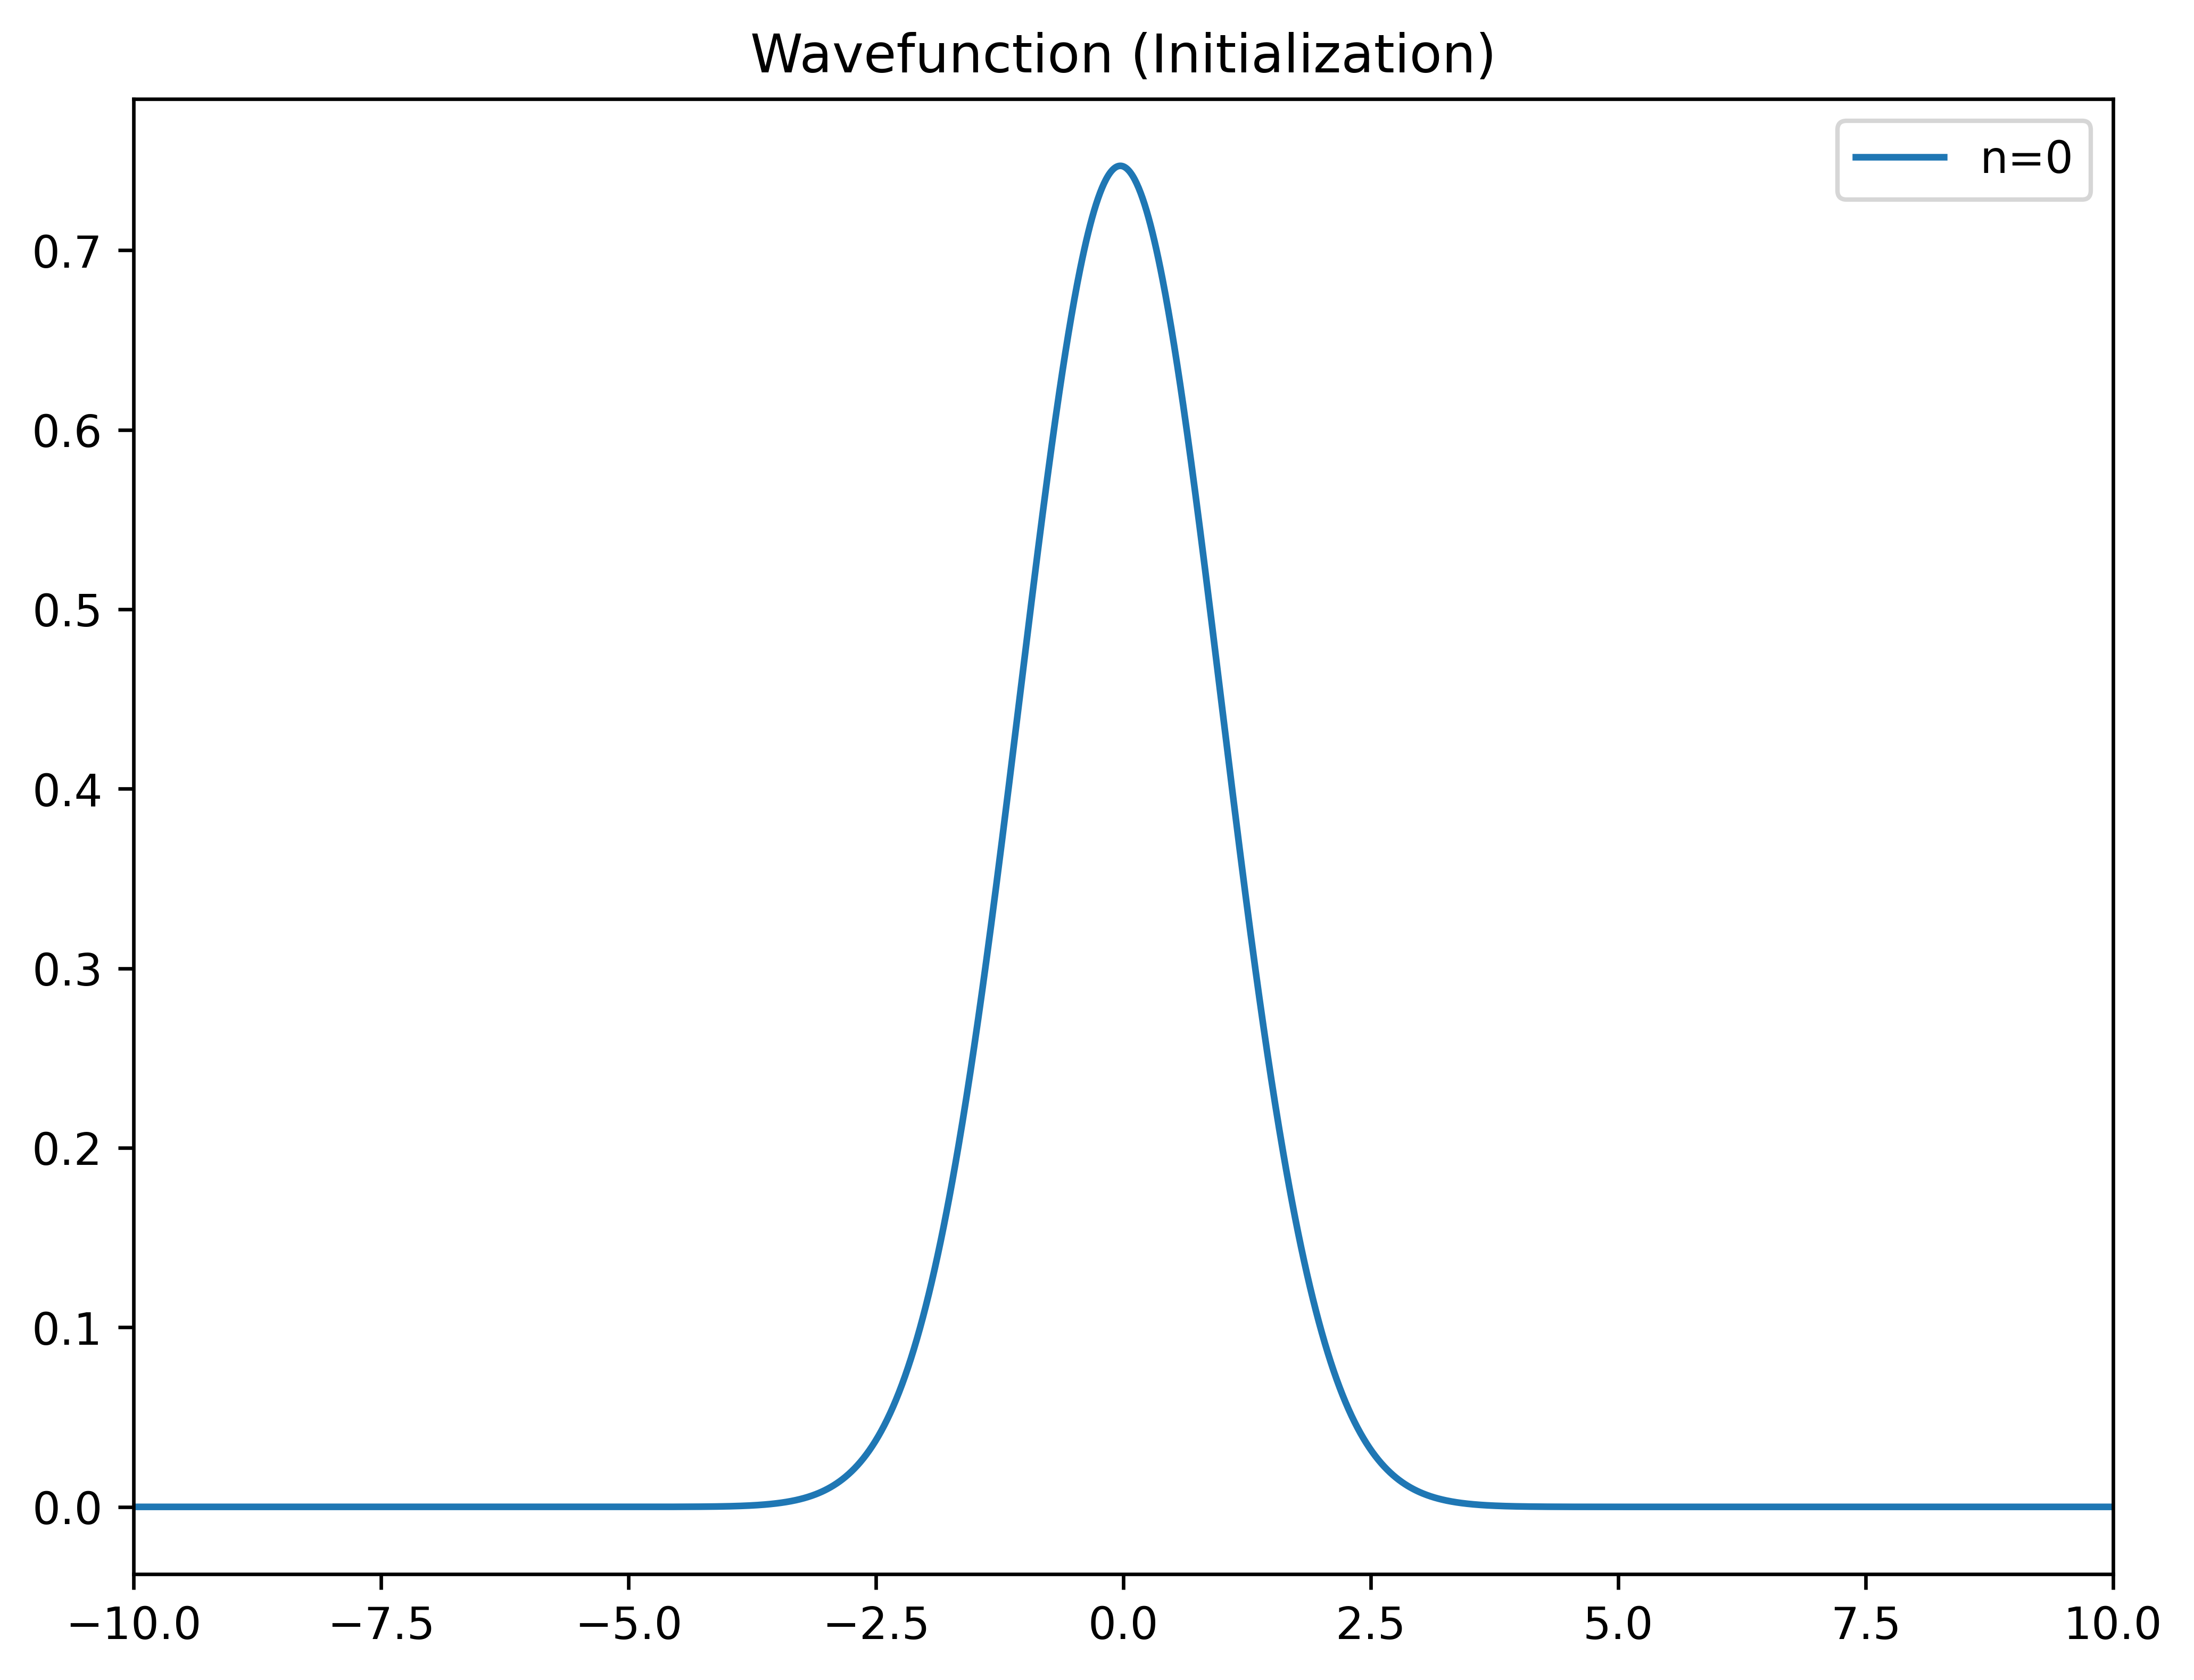

Thermalization...
After Thermalization:	pmove 0.46	step_size=1.3566	time=3.75s
After MCMC, with initial network, loss=1.08


  0%|          | 0/5000 [00:00<?, ?it/s]

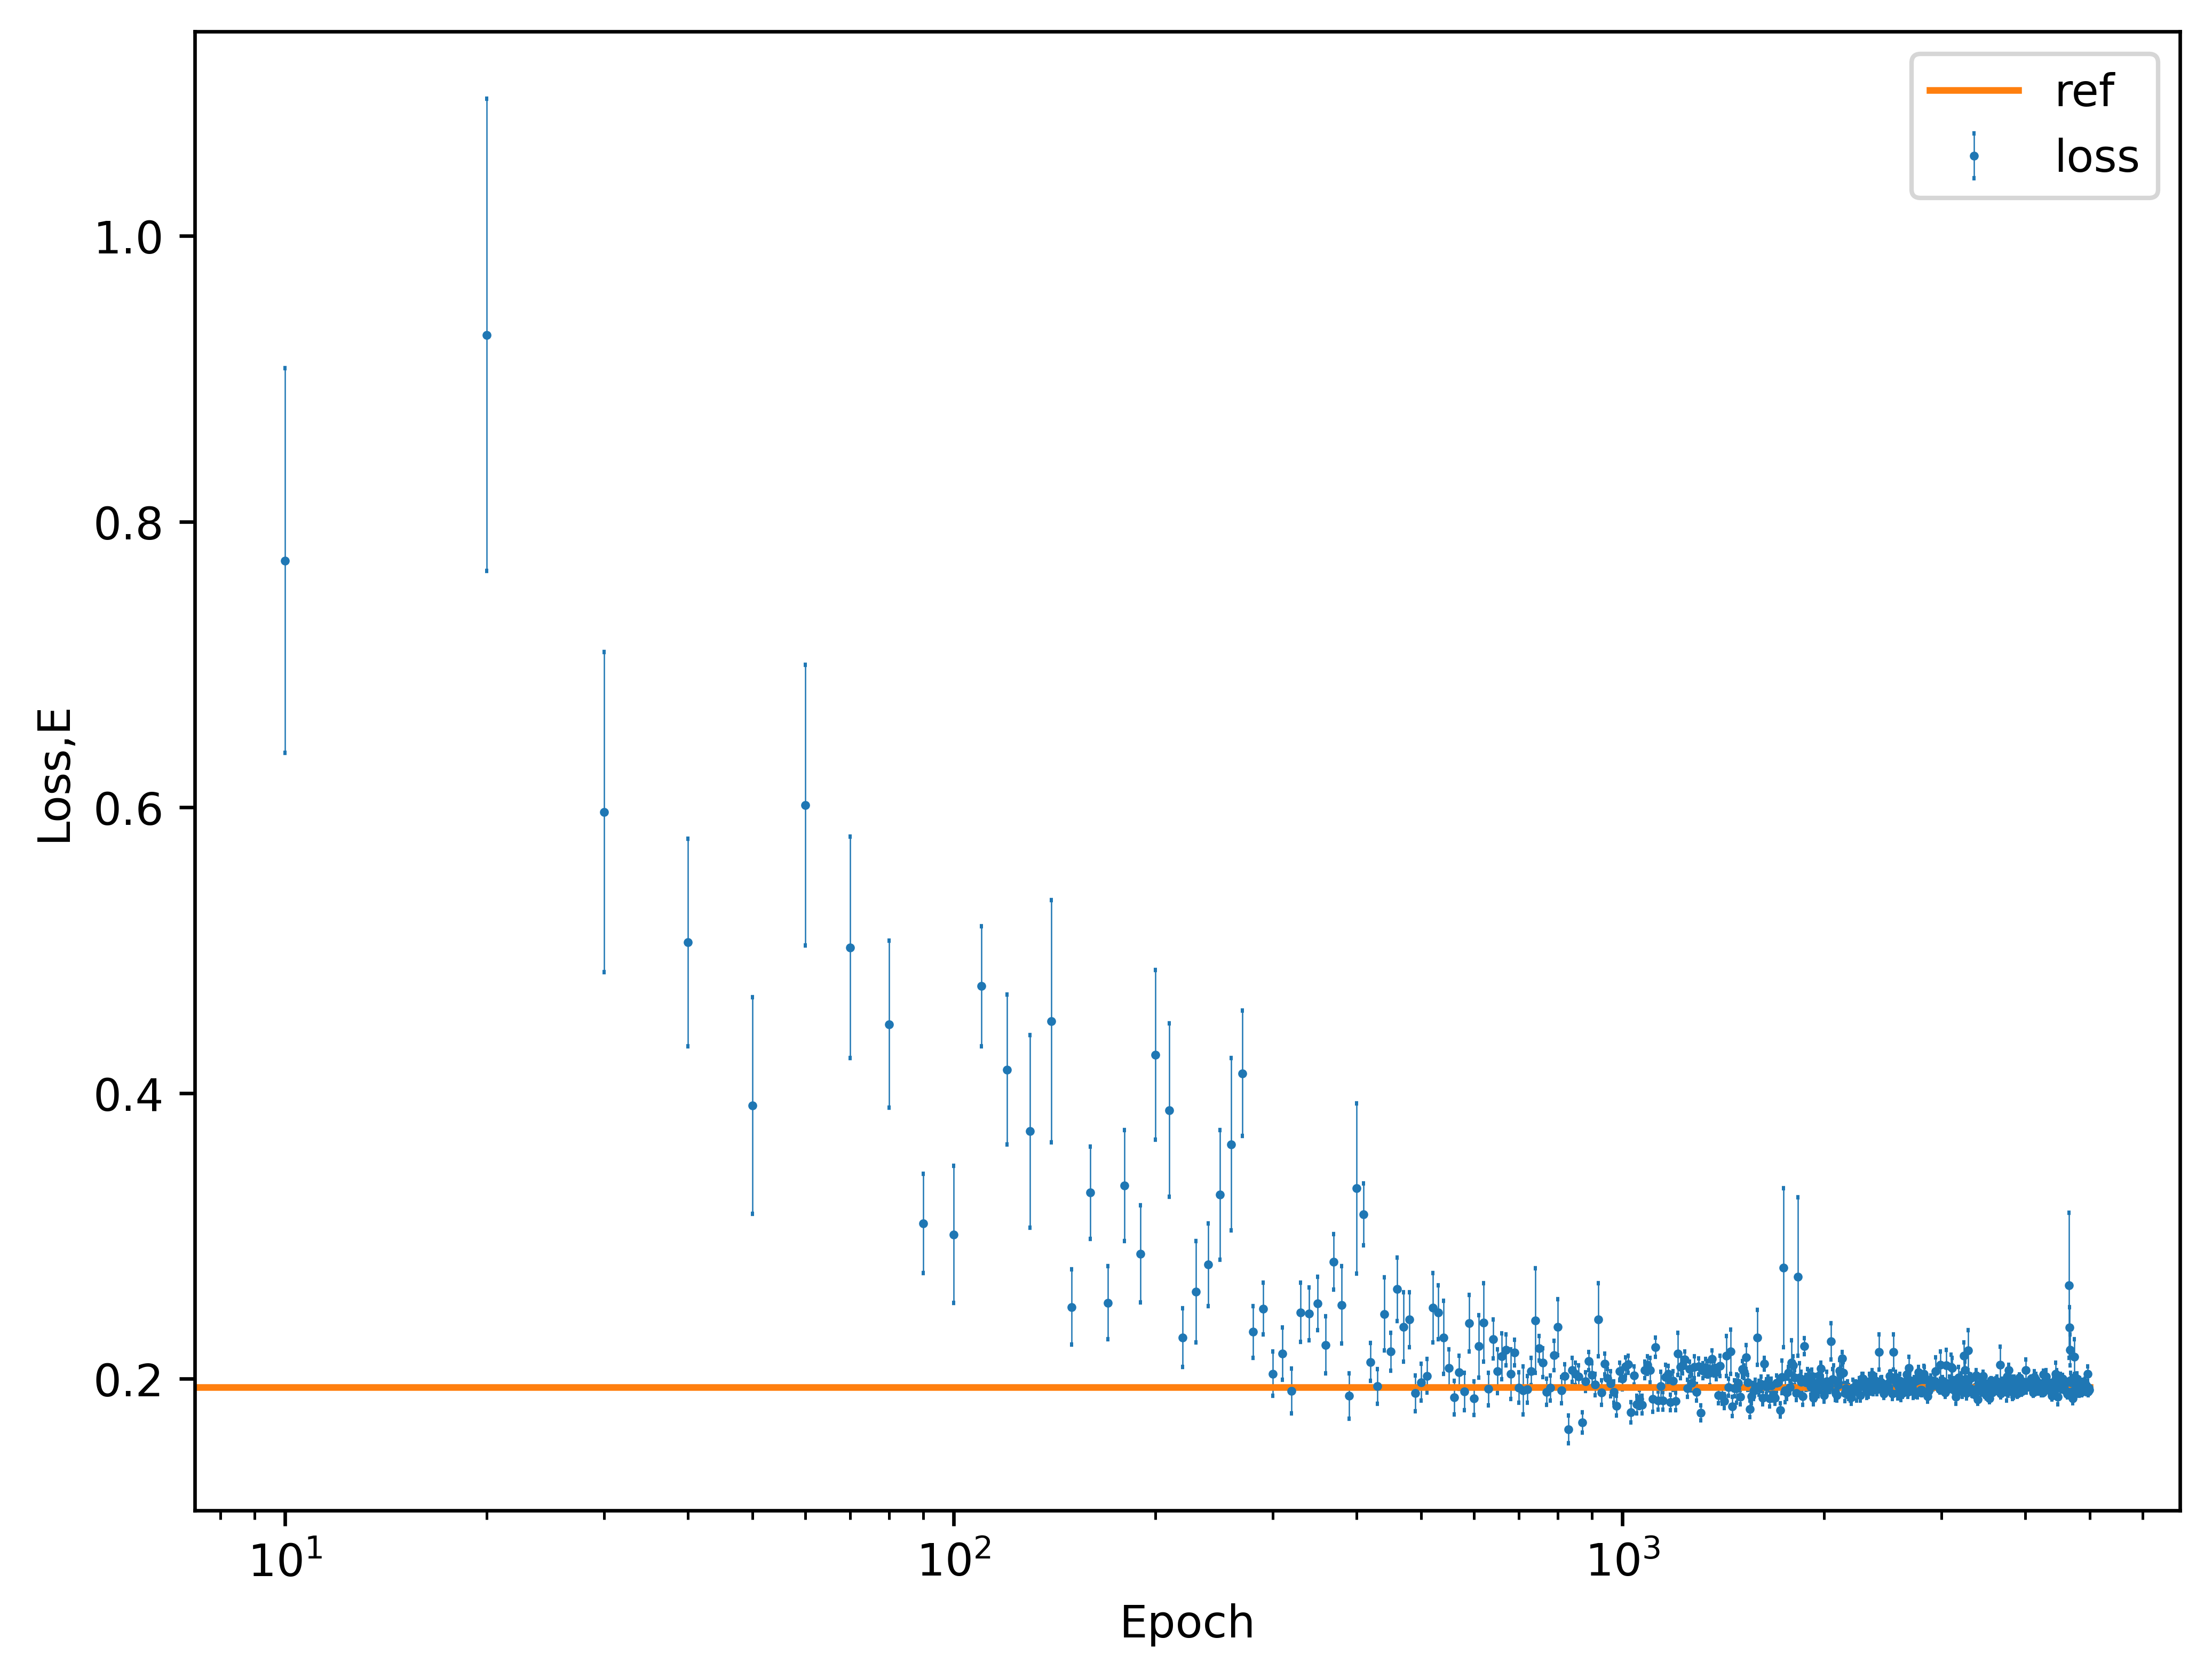

Probability Density (Trained)


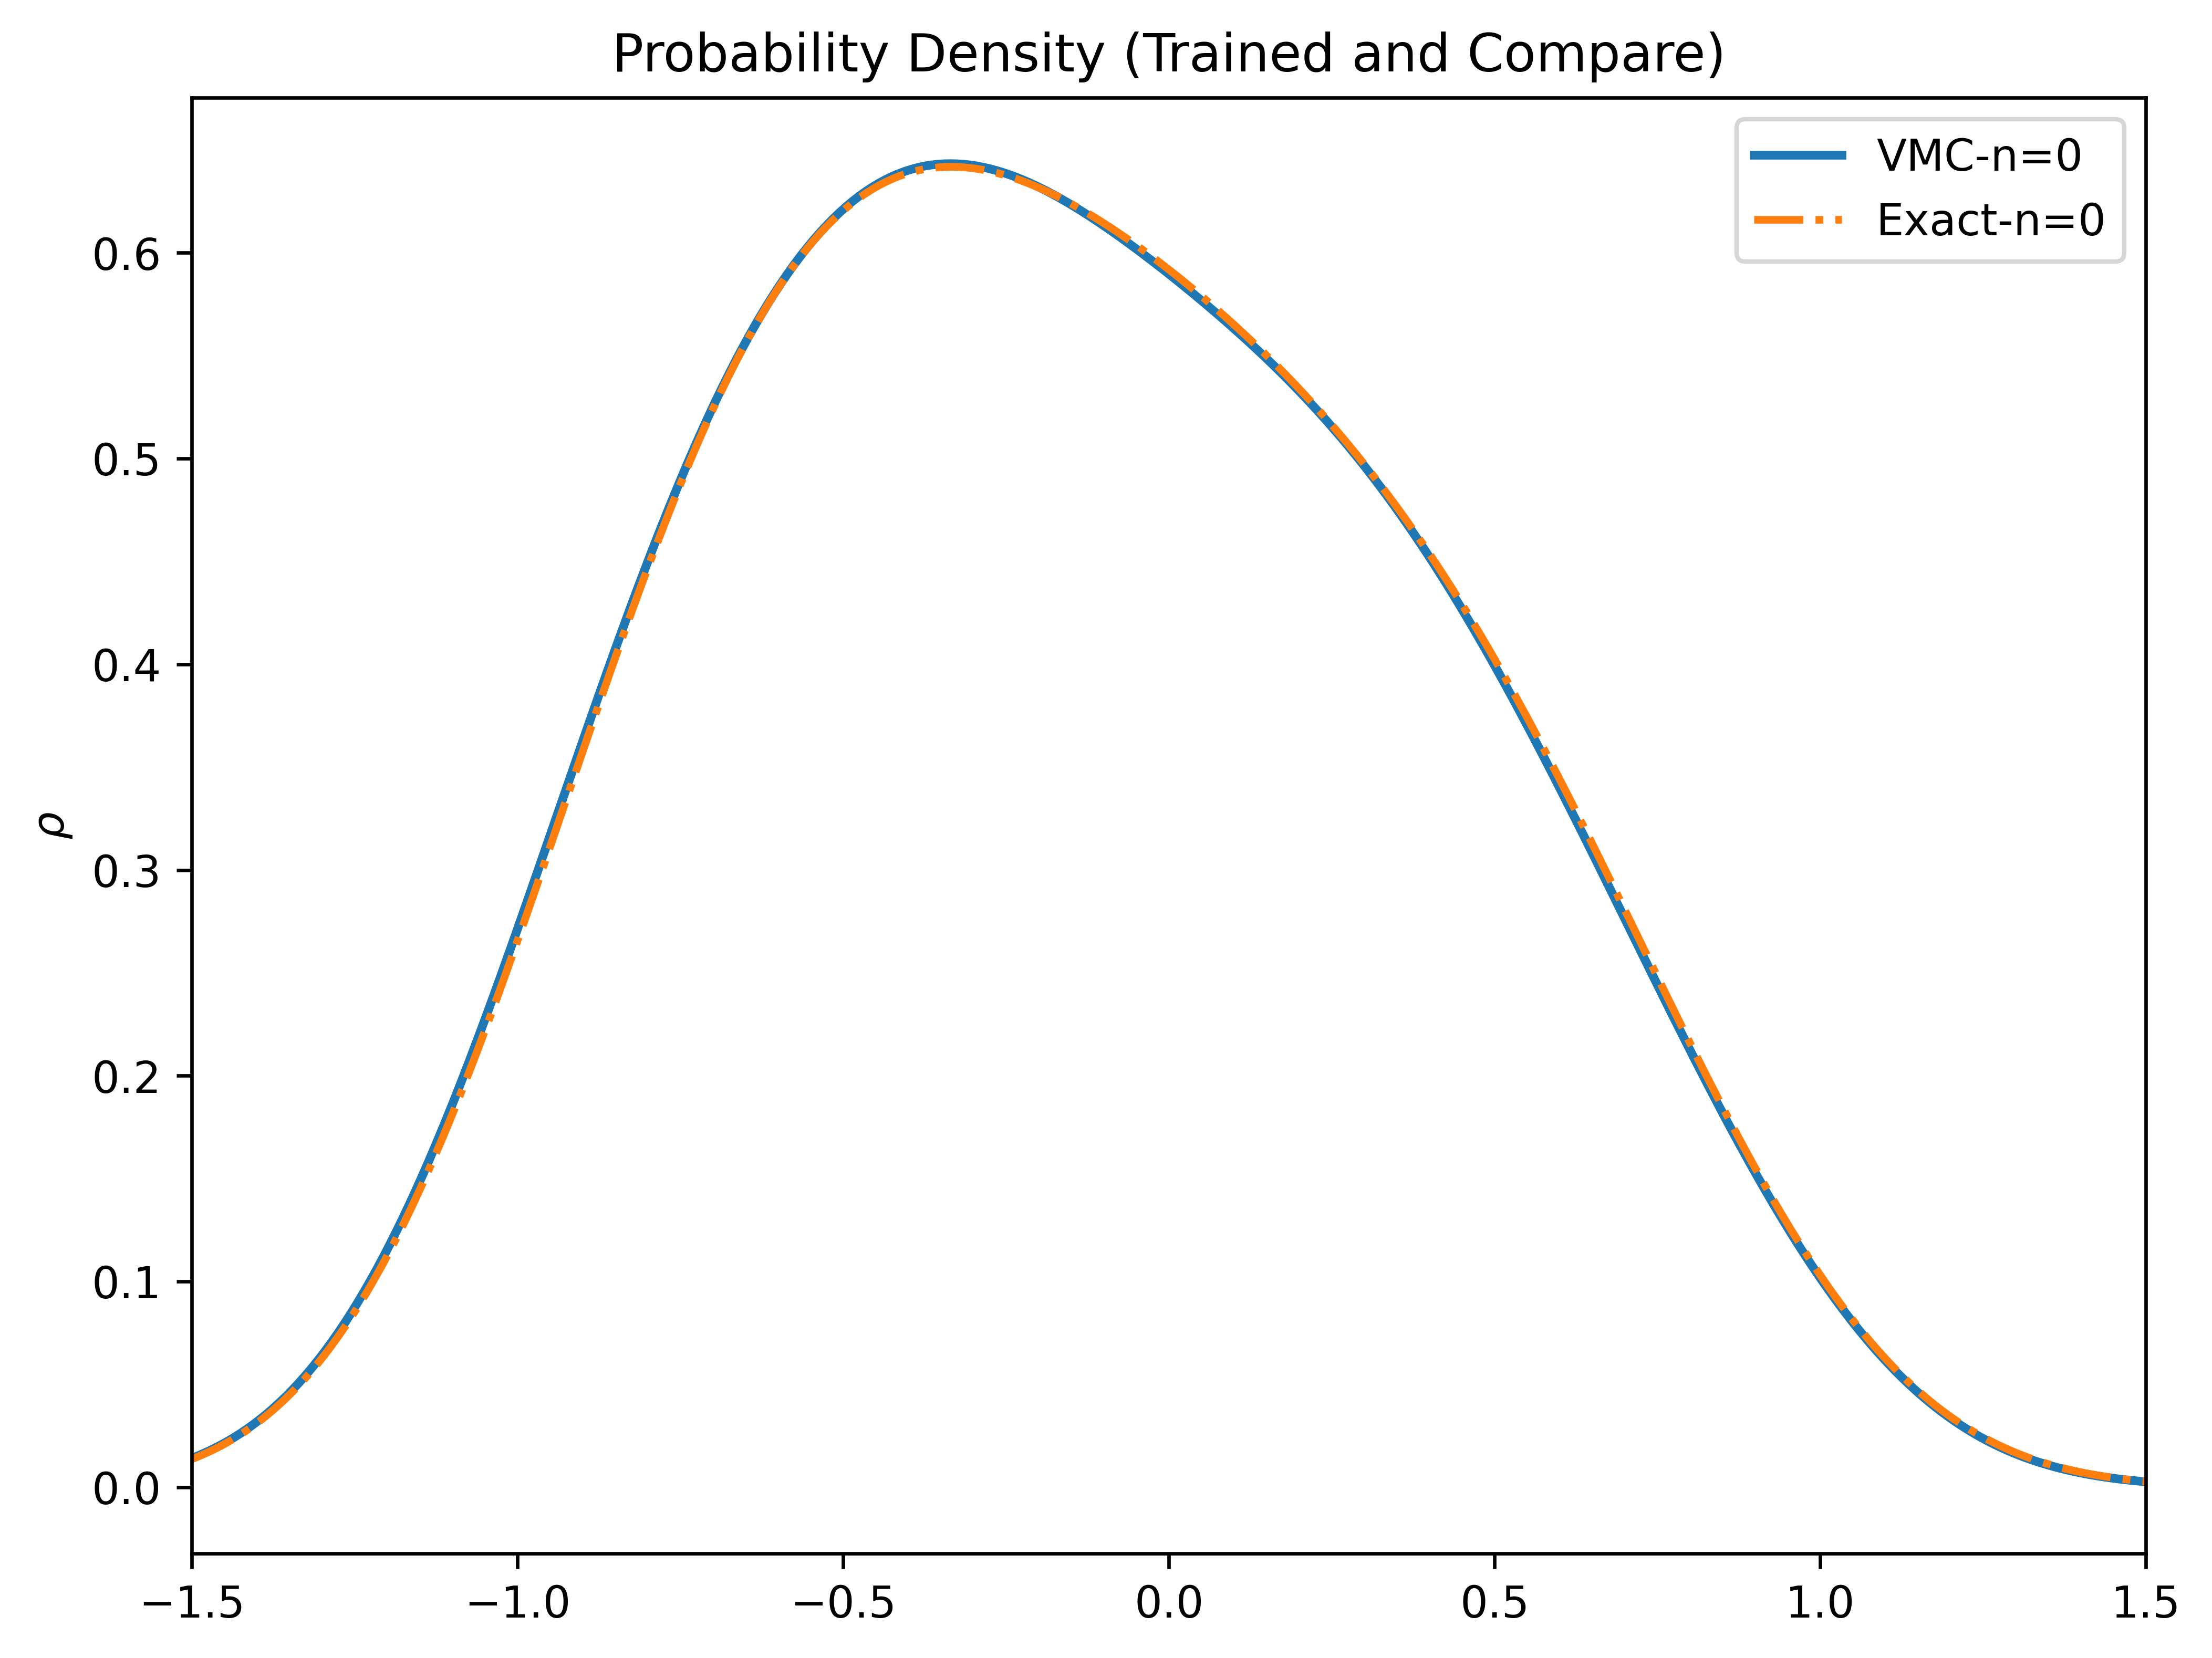

...Inferencing...
Thermalization...
After Thermalization:	pmove 0.53	step_size=1.1968	time=24.64s
Mesuring Energy...

VMC Result with 1 states:

n=0	energy=0.19336(0.00183)


Exact Result with 1 states:

n=0	energy=0.19457

=======================GS=========================


In [20]:
total_num_of_states = 1
key = jax.random.PRNGKey(42)
# System settings
batch_size = 500
thermal_step = 20
acc_steps = 2
mc_steps = 20
step_size = 1.5
num_substeps = 1  # DONT MOVE!
init_width = 1.5
mlp_width = 3
mlp_depth = 3
init_learning_rate = 2e-2
iterations = 5000
figure_save_path = None
inference_batch_size = 10000
inference_thermal_step = 50

training_args = {
    "key": key,
    "batch_size": batch_size,
    "total_num_of_states": total_num_of_states,
    "thermal_step": thermal_step,
    "acc_steps": acc_steps,
    "mc_steps": mc_steps,
    "step_size": step_size,
    "num_substeps": num_substeps,
    "init_width": init_width,
    "mlp_width": mlp_width,
    "mlp_depth": mlp_depth,
    "init_learning_rate": init_learning_rate,
    "iterations": iterations,
    "inference_batch_size": inference_batch_size,
    "inference_thermal_step": inference_thermal_step,
    "figure_save_path": figure_save_path,
}
training_kernel(training_args,savefig = False)



### Excited States (Variational)

The flow method enables us to calculate excited states alongside with ground state, but before we move on, we seek for some strategy to prepare a better basis that the flow would start from.

One routine way to find a better basis would be Variational Self-Consistent Field(VSCF), which fits the Tylor expansion form potential well (and is the case we are dealing with). 

> A detailed VSCF guide for novice: [Anharmonic Vibrational States of Solids from DFT Calculations. Part II: Implementation of the VSCF and VCI Methods](https://pubs.acs.org/doi/10.1021/acs.jctc.9b00294), sec IIA.

> But NOTE here we are dealing with a one-dimensional system, hence we use the 1d analogy of VSCF:


#### Preparing the Basis: One-dimensional Analogy of VSCF

Under current situation, the system we are dealing is equavilant to setting `M=1` and $V_c(Q)=0$ in VSCF in the reference paper: [Anharmonic Vibrational States of Solids from DFT Calculations. Part II: Implementation of the VSCF and VCI Methods](https://pubs.acs.org/doi/10.1021/acs.jctc.9b00294). 

Hence the wavefunction reduced to 

$$
\Phi^n(Q) = \phi^n(Q)
$$

Then expanded as

$$
\phi^n(Q) = \sum_{\nu=1}^{Nlev} C_{\nu,n} \psi^\nu (Q)
$$

Here $\psi^\nu$ are the eigenfunctions of the Harmonic Oscillator: 


$$
\psi^{\nu} ( Q )=\left( \frac{\sqrt{\omega}} {\sqrt{\pi} 2^{\nu} \nu!} \right)^{1 / 2} H_{\nu} ( \xi ) e^{-\xi^{2} / 2} 
$$


Since $V_c(Q) = 0$ then 

$$
H = h + V_c(Q) = h
$$

and we have

$$
H = -\frac{1}{2} \frac{\partial^2}{\partial Q^2} - 3 Q^2 + \frac{1}{2}Q^3 + 3Q^4
$$

Diagonalizing the Hamiltonian gives us the best estimation of the mixed basis:

$$
H C = C E
$$

Here C is the eigenvectors, E is the diagonal matrix of eigenvalues.
H is the Hamiltonian expressed in matrix form:

$$
H_{\nu \mu} = <\psi^\nu|H|\psi^\mu>
$$

VSCF with Nlevel = 30
After optimization,
Total energy = 1.930166767433022
Ref Energy = 1.929708100724059


Text(0.5, 1.0, 'Probability Density (Trained and Compare)')

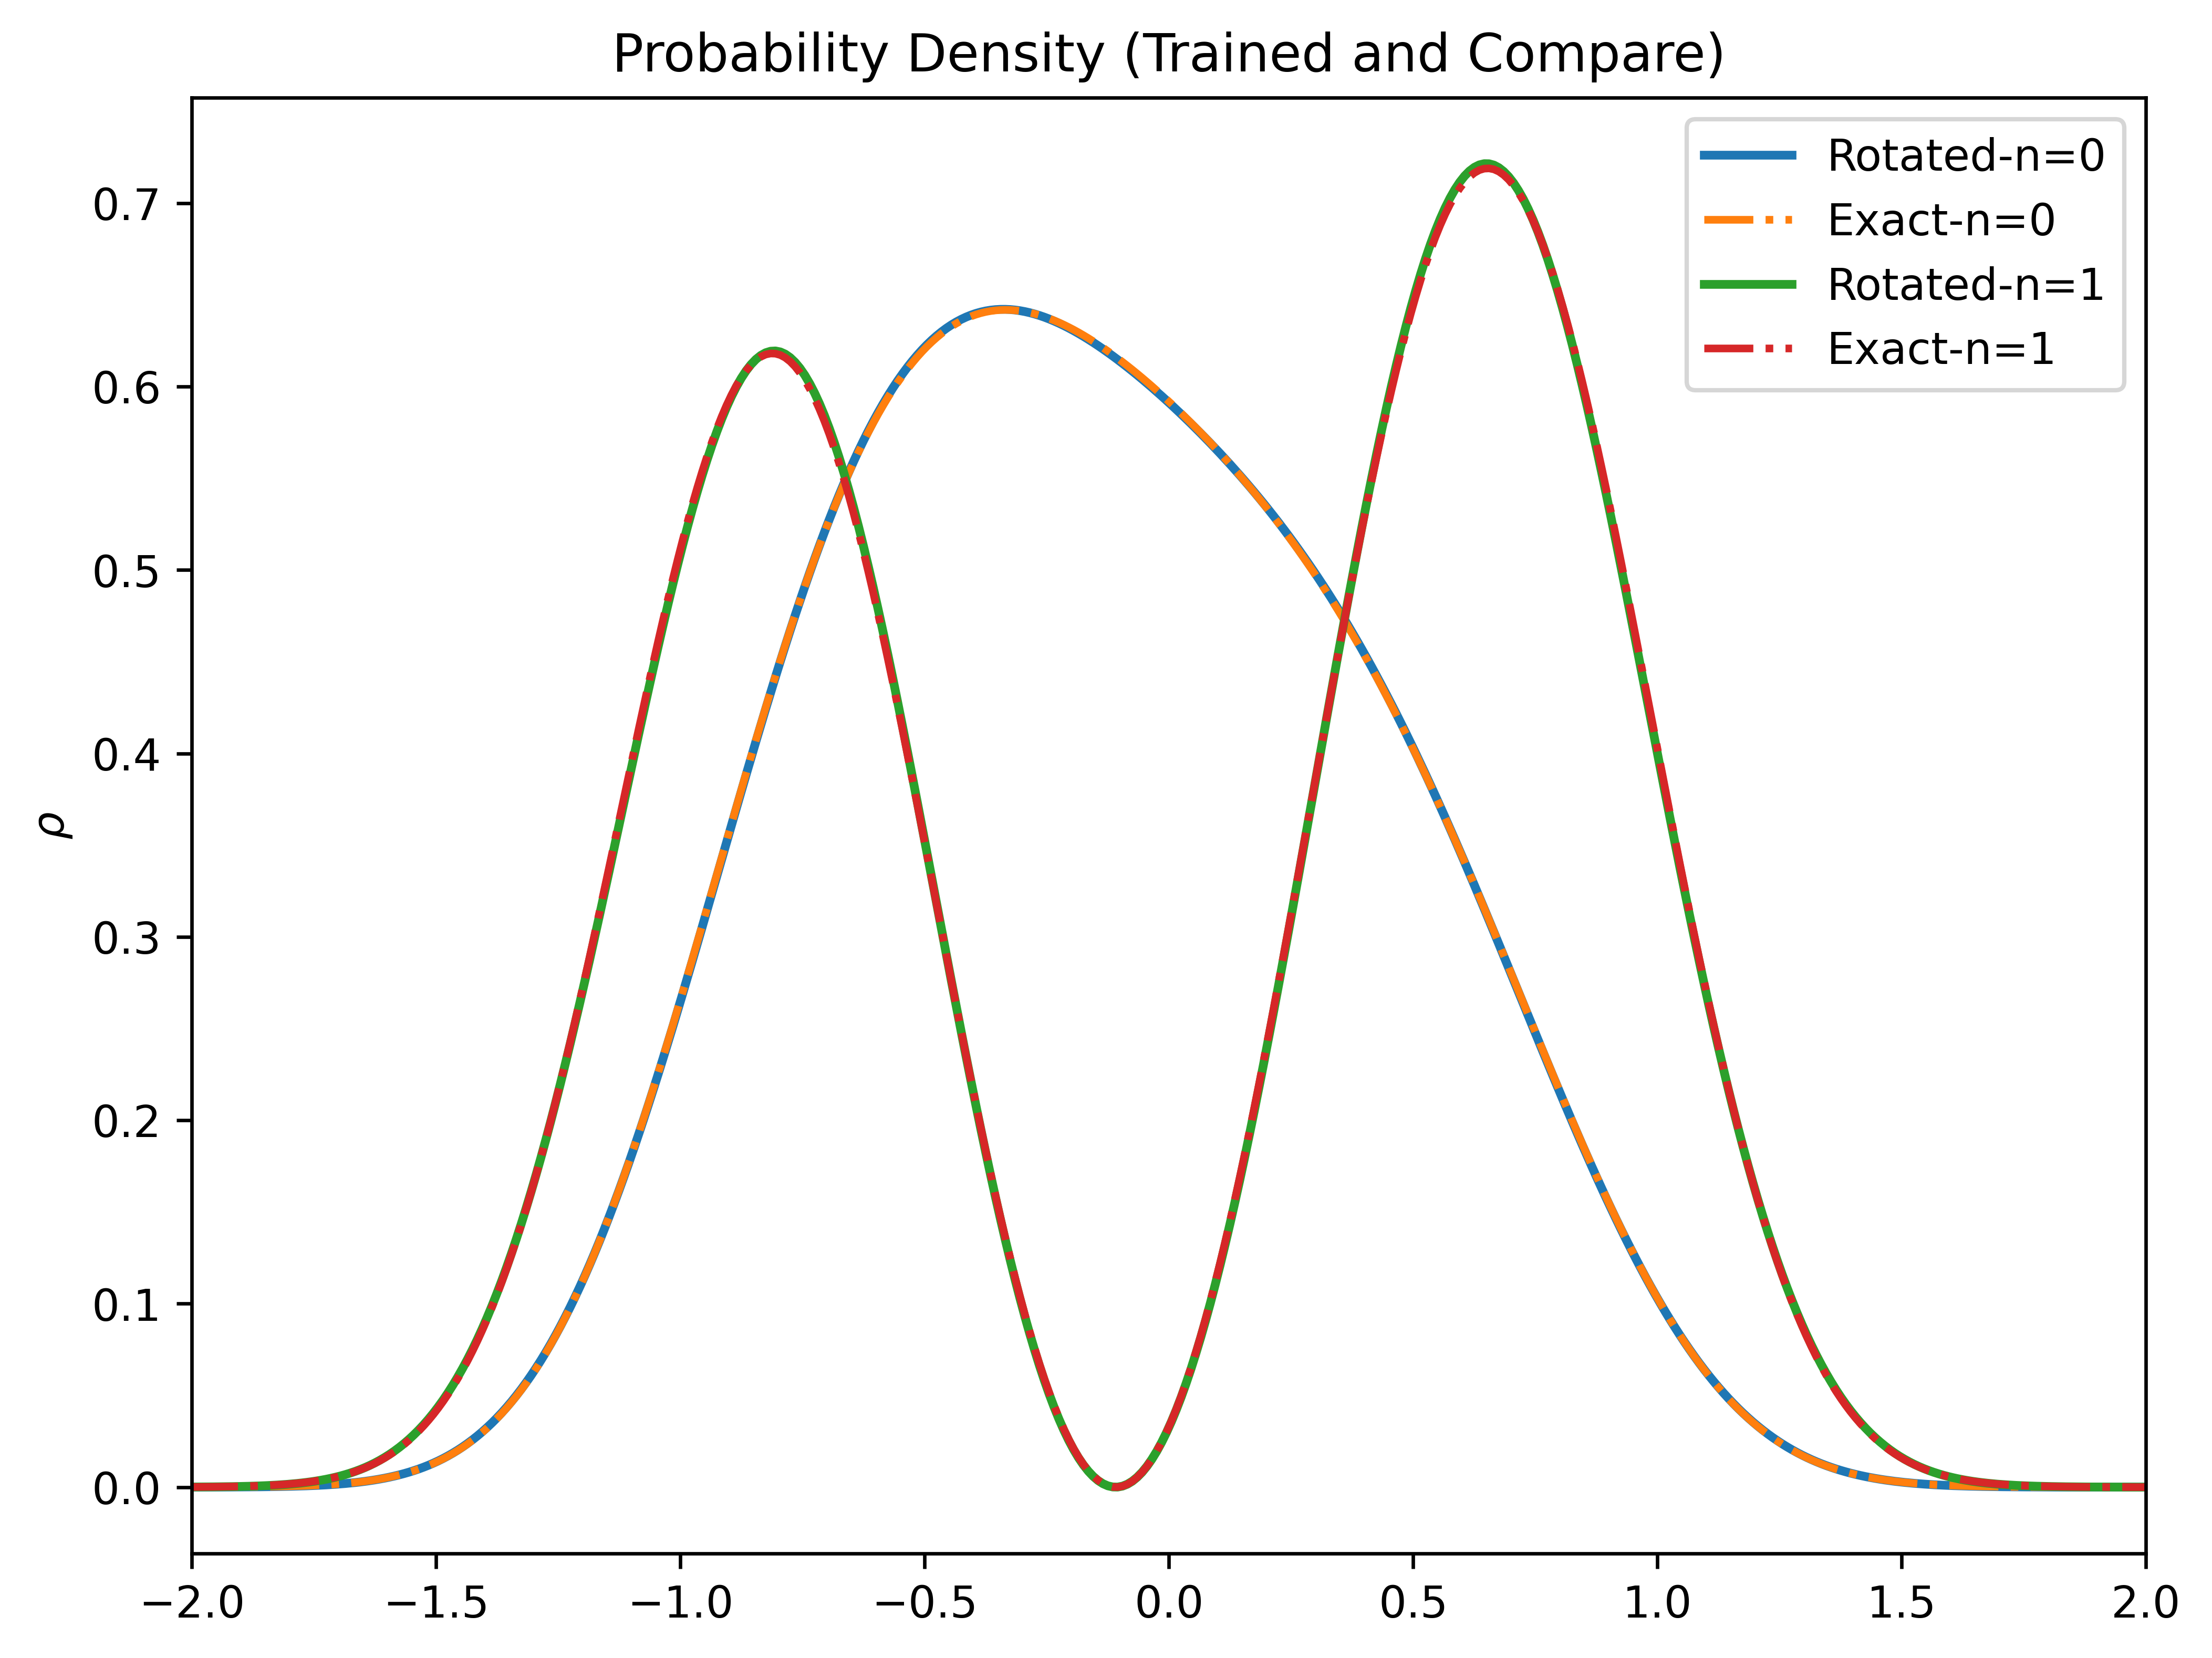

In [23]:
from VMC.utils import wf_base_indices_vmapped
from VMC.utils import buildH
from VMC.utils import EnergyEstimator as VMCEnergyEstimator
from VMC.vscf.vscf1d import VSCF

def _wf_base_vscf(
    x: float | jax.Array,
    n: int,
    coeff: np.ndarray,
) -> jax.Array:
    """The wave function ansatz (Rotated Gaussian)
    NOTE: Rotated! Rotation is solved by VSCF
    NOTE: Rotated total states should be larger than called argument n.

    Args:
        x: the 1D coordinate of the (single) particle.
        n: the excitation quantum number
        coeff: (nlevel,nlevel) the solved VSCF coefficients.

        NOTE: n=0 for GS!

    Returns:
        psi: the probability amplitude at x.
    """
    nlevel = coeff.shape[0]
    mix_indices = jnp.array(range(nlevel))
    mix_rot_coeff = coeff[:, n]
    wf_for_mix = wf_base_indices_vmapped(x, mix_indices)
    psi = jnp.dot(mix_rot_coeff, wf_for_mix)
    return psi

xmin = -10
xmax = 10
Nmesh = 2000
xmesh = jnp.linspace(xmin, xmax, Nmesh)
interval = xmesh[1] - xmesh[0]

nlevel = 30

def wf_gs(coeff, x):
    return _wf_base_vscf(x, 0, coeff)

def wf_1st(coeff, x):
    return _wf_base_vscf(x, 1, coeff)

wf_gs_vmapped = jax.vmap(wf_gs, in_axes=(None, 0))
wf_first_vmapped = jax.vmap(wf_1st, in_axes=(None, 0))

vscf_obj = VSCF(nlevel=nlevel)
energies, coeff = vscf_obj.solver()
totalen = np.sum(energies[:2:])

print("=" * 50)

# Finite Differential Method
# which would be <exact> if our mesh intervals are small enough
potential_func = VMCEnergyEstimator.local_potential_energy
H = buildH(potential_func, xmesh, Nmesh, interval)
exact_eigenvalues, exact_eigenvectors = scipy.linalg.eigh(H)
trained_states_energy = exact_eigenvalues[range(2)]
expectedenergy = np.sum(trained_states_energy)
print(
    f"After optimization,\nTotal energy = {totalen}\nRef Energy = {expectedenergy}"
)

plt.figure()
for i in range(2):
    if i == 0:
        wf_gs_on_mesh = wf_gs_vmapped(coeff, xmesh)
        normalize_gs = jnp.sum(wf_gs_vmapped(coeff, xmesh) ** 2 * interval)
        wf_gs_on_mesh = wf_gs_on_mesh**2 / normalize_gs
        plt.plot(xmesh, wf_gs_on_mesh, label=f"Rotated-n={i}", lw=2)
    if i == 1:
        wf_1st_on_mesh = wf_first_vmapped(coeff, xmesh)
        normalize_1st = jnp.sum(wf_first_vmapped(coeff, xmesh) ** 2 * interval)
        wf_1st_on_mesh = wf_1st_on_mesh**2 / normalize_1st
        plt.plot(xmesh, wf_1st_on_mesh, label=f"Rotated-n={i}", lw=2)

    exact_wf_on_mesh = exact_eigenvectors[:, i]
    normalize_factor = (exact_wf_on_mesh**2).sum() * interval
    exact_prob_density = exact_wf_on_mesh**2 / normalize_factor
    plt.plot(xmesh, exact_prob_density, "-.", label=f"Exact-n={i}", lw=1.75)
plt.xlim([-2.0, 2.0])
plt.legend()
plt.ylabel(r"$\rho$")
plt.title("Probability Density (Trained and Compare)")

Then using VSCF basis, we can perform the calculation to excited states, as we've done before:

In [24]:
%reset

Nothing done.


Computed States Indices: [0, 1]
Init Jacobian at x=0.0 = 
[1.00000009]
Number of params:301
VSCF with Nlevel = 30
VSCF Energy = 1.930166767433022
Wavefunction (Initialization)


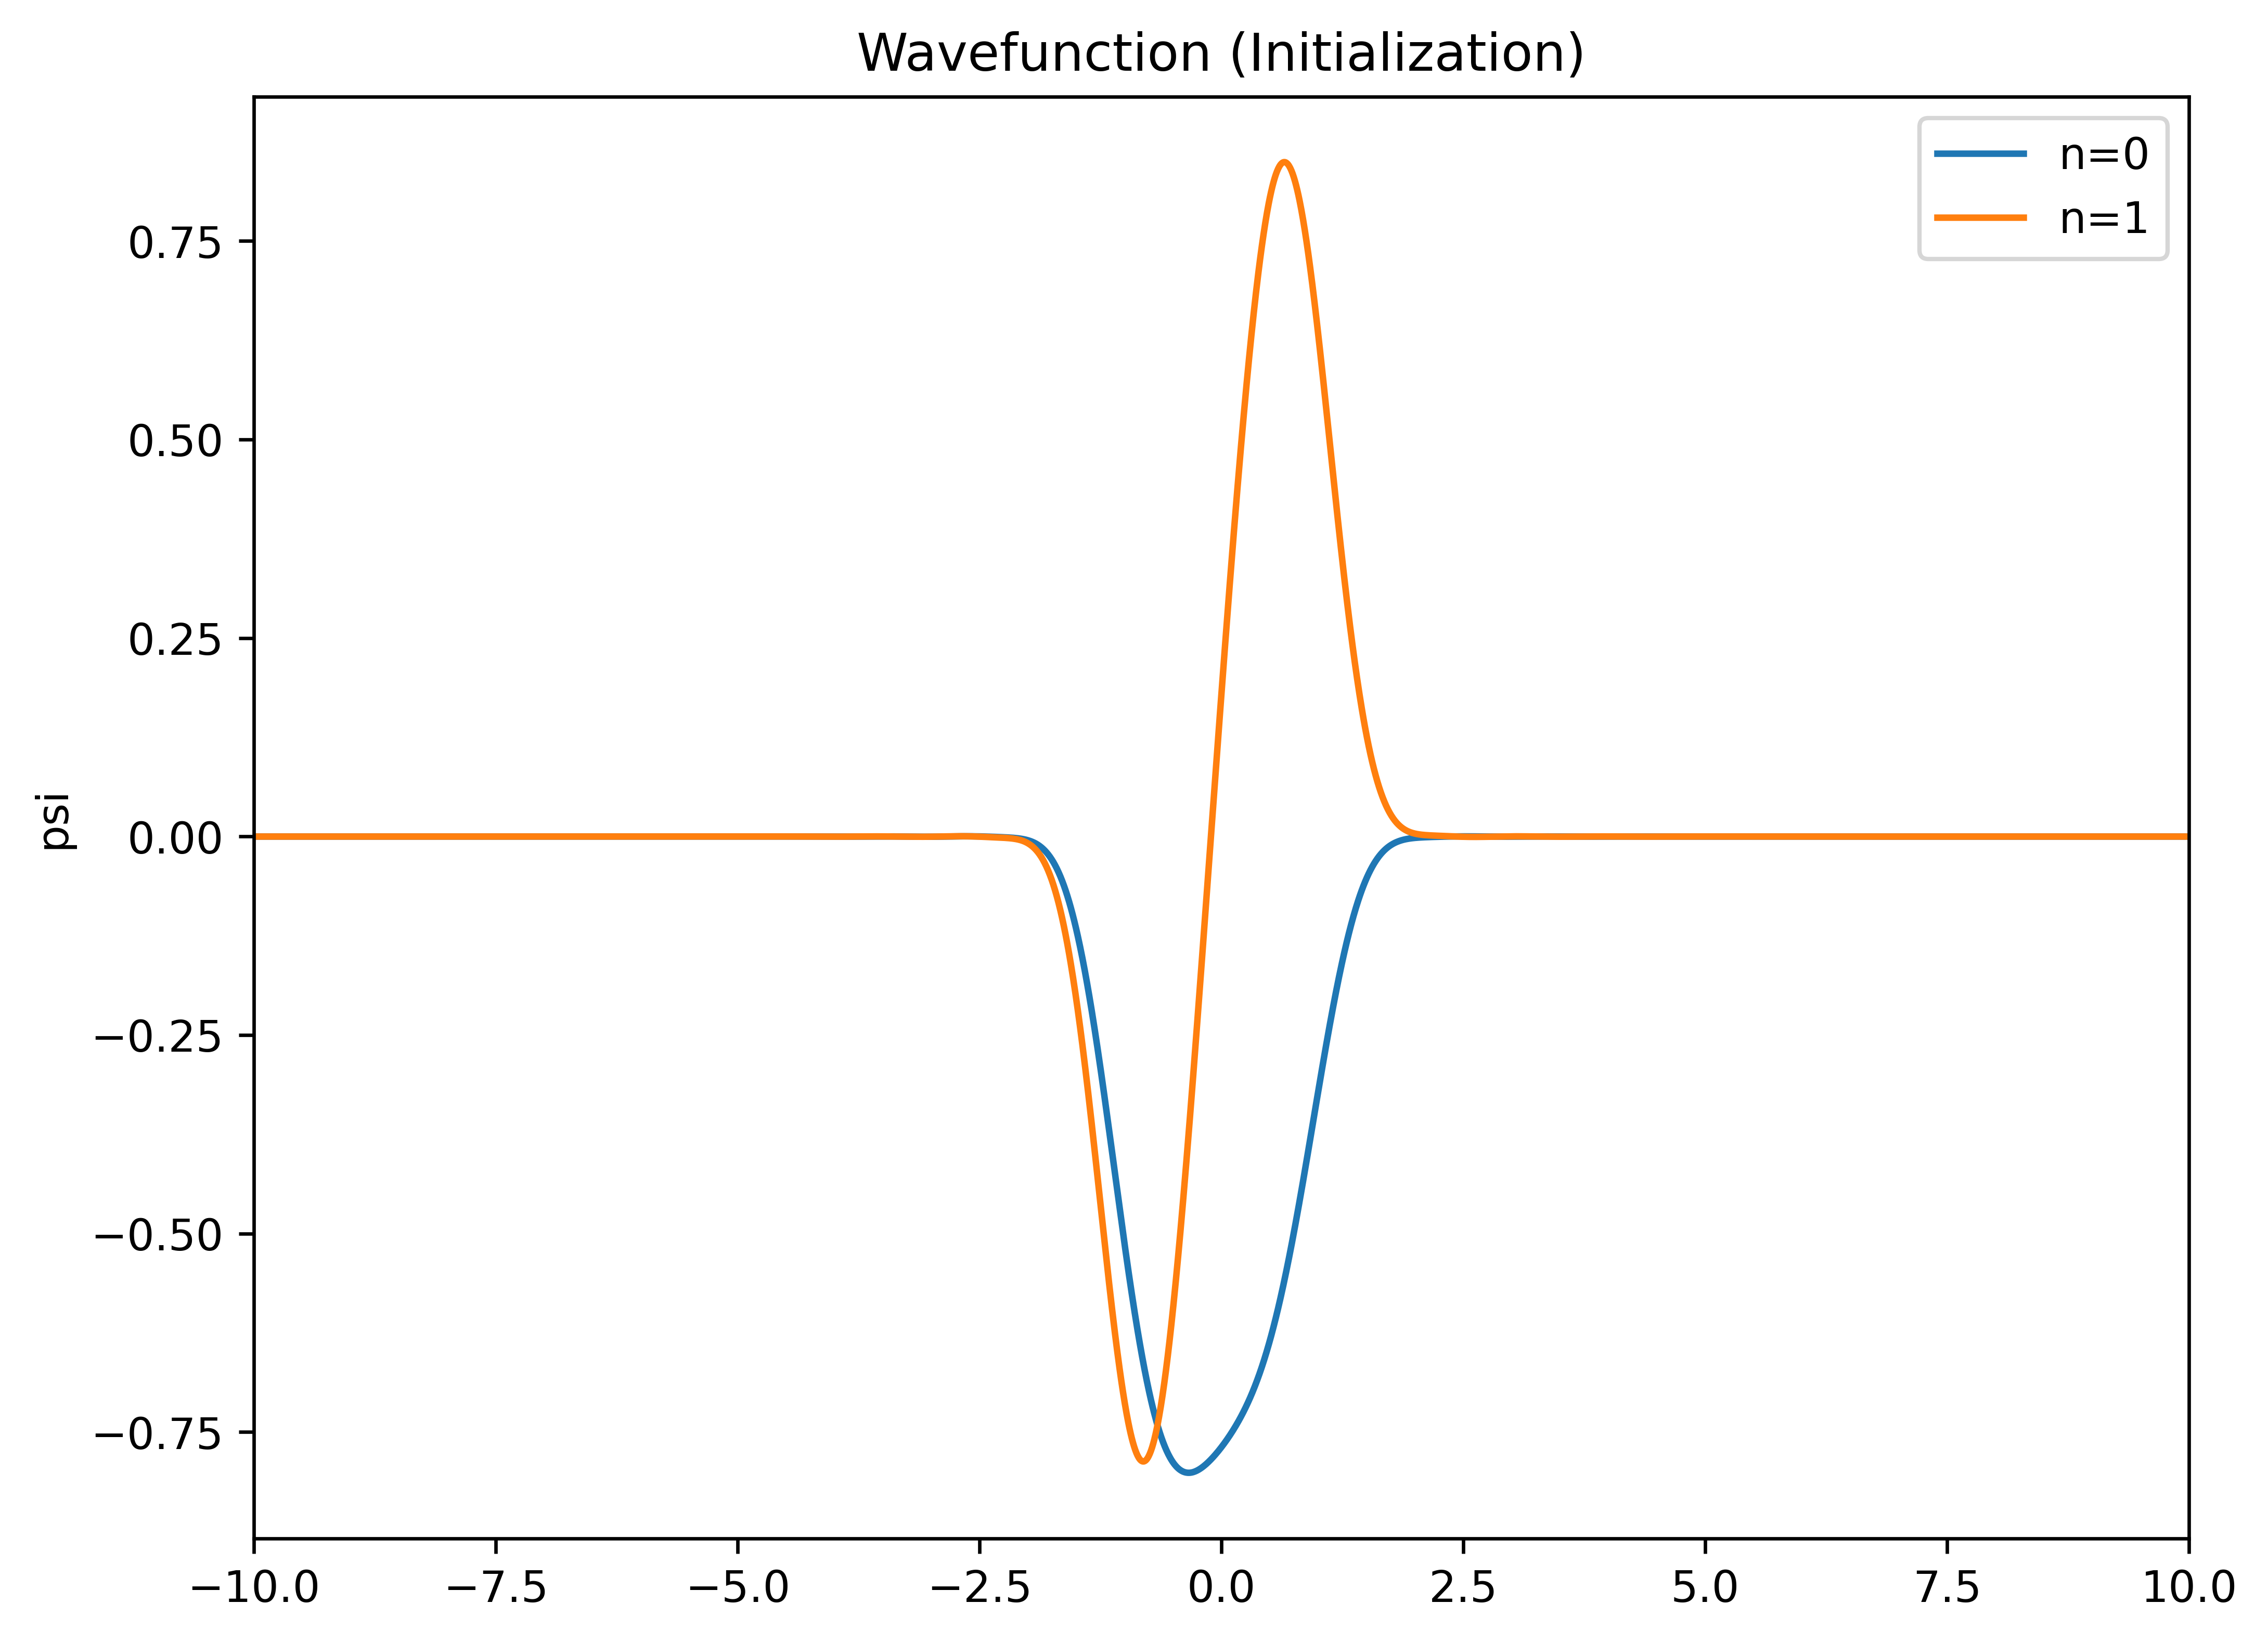

Thermalization...
After Thermalization:	pmove [0.83935 0.70515]	step_size=[0.3 0.3]	time=3.18s
After MCMC, with initial network, loss=1.94


  0%|          | 0/1000 [00:00<?, ?it/s]

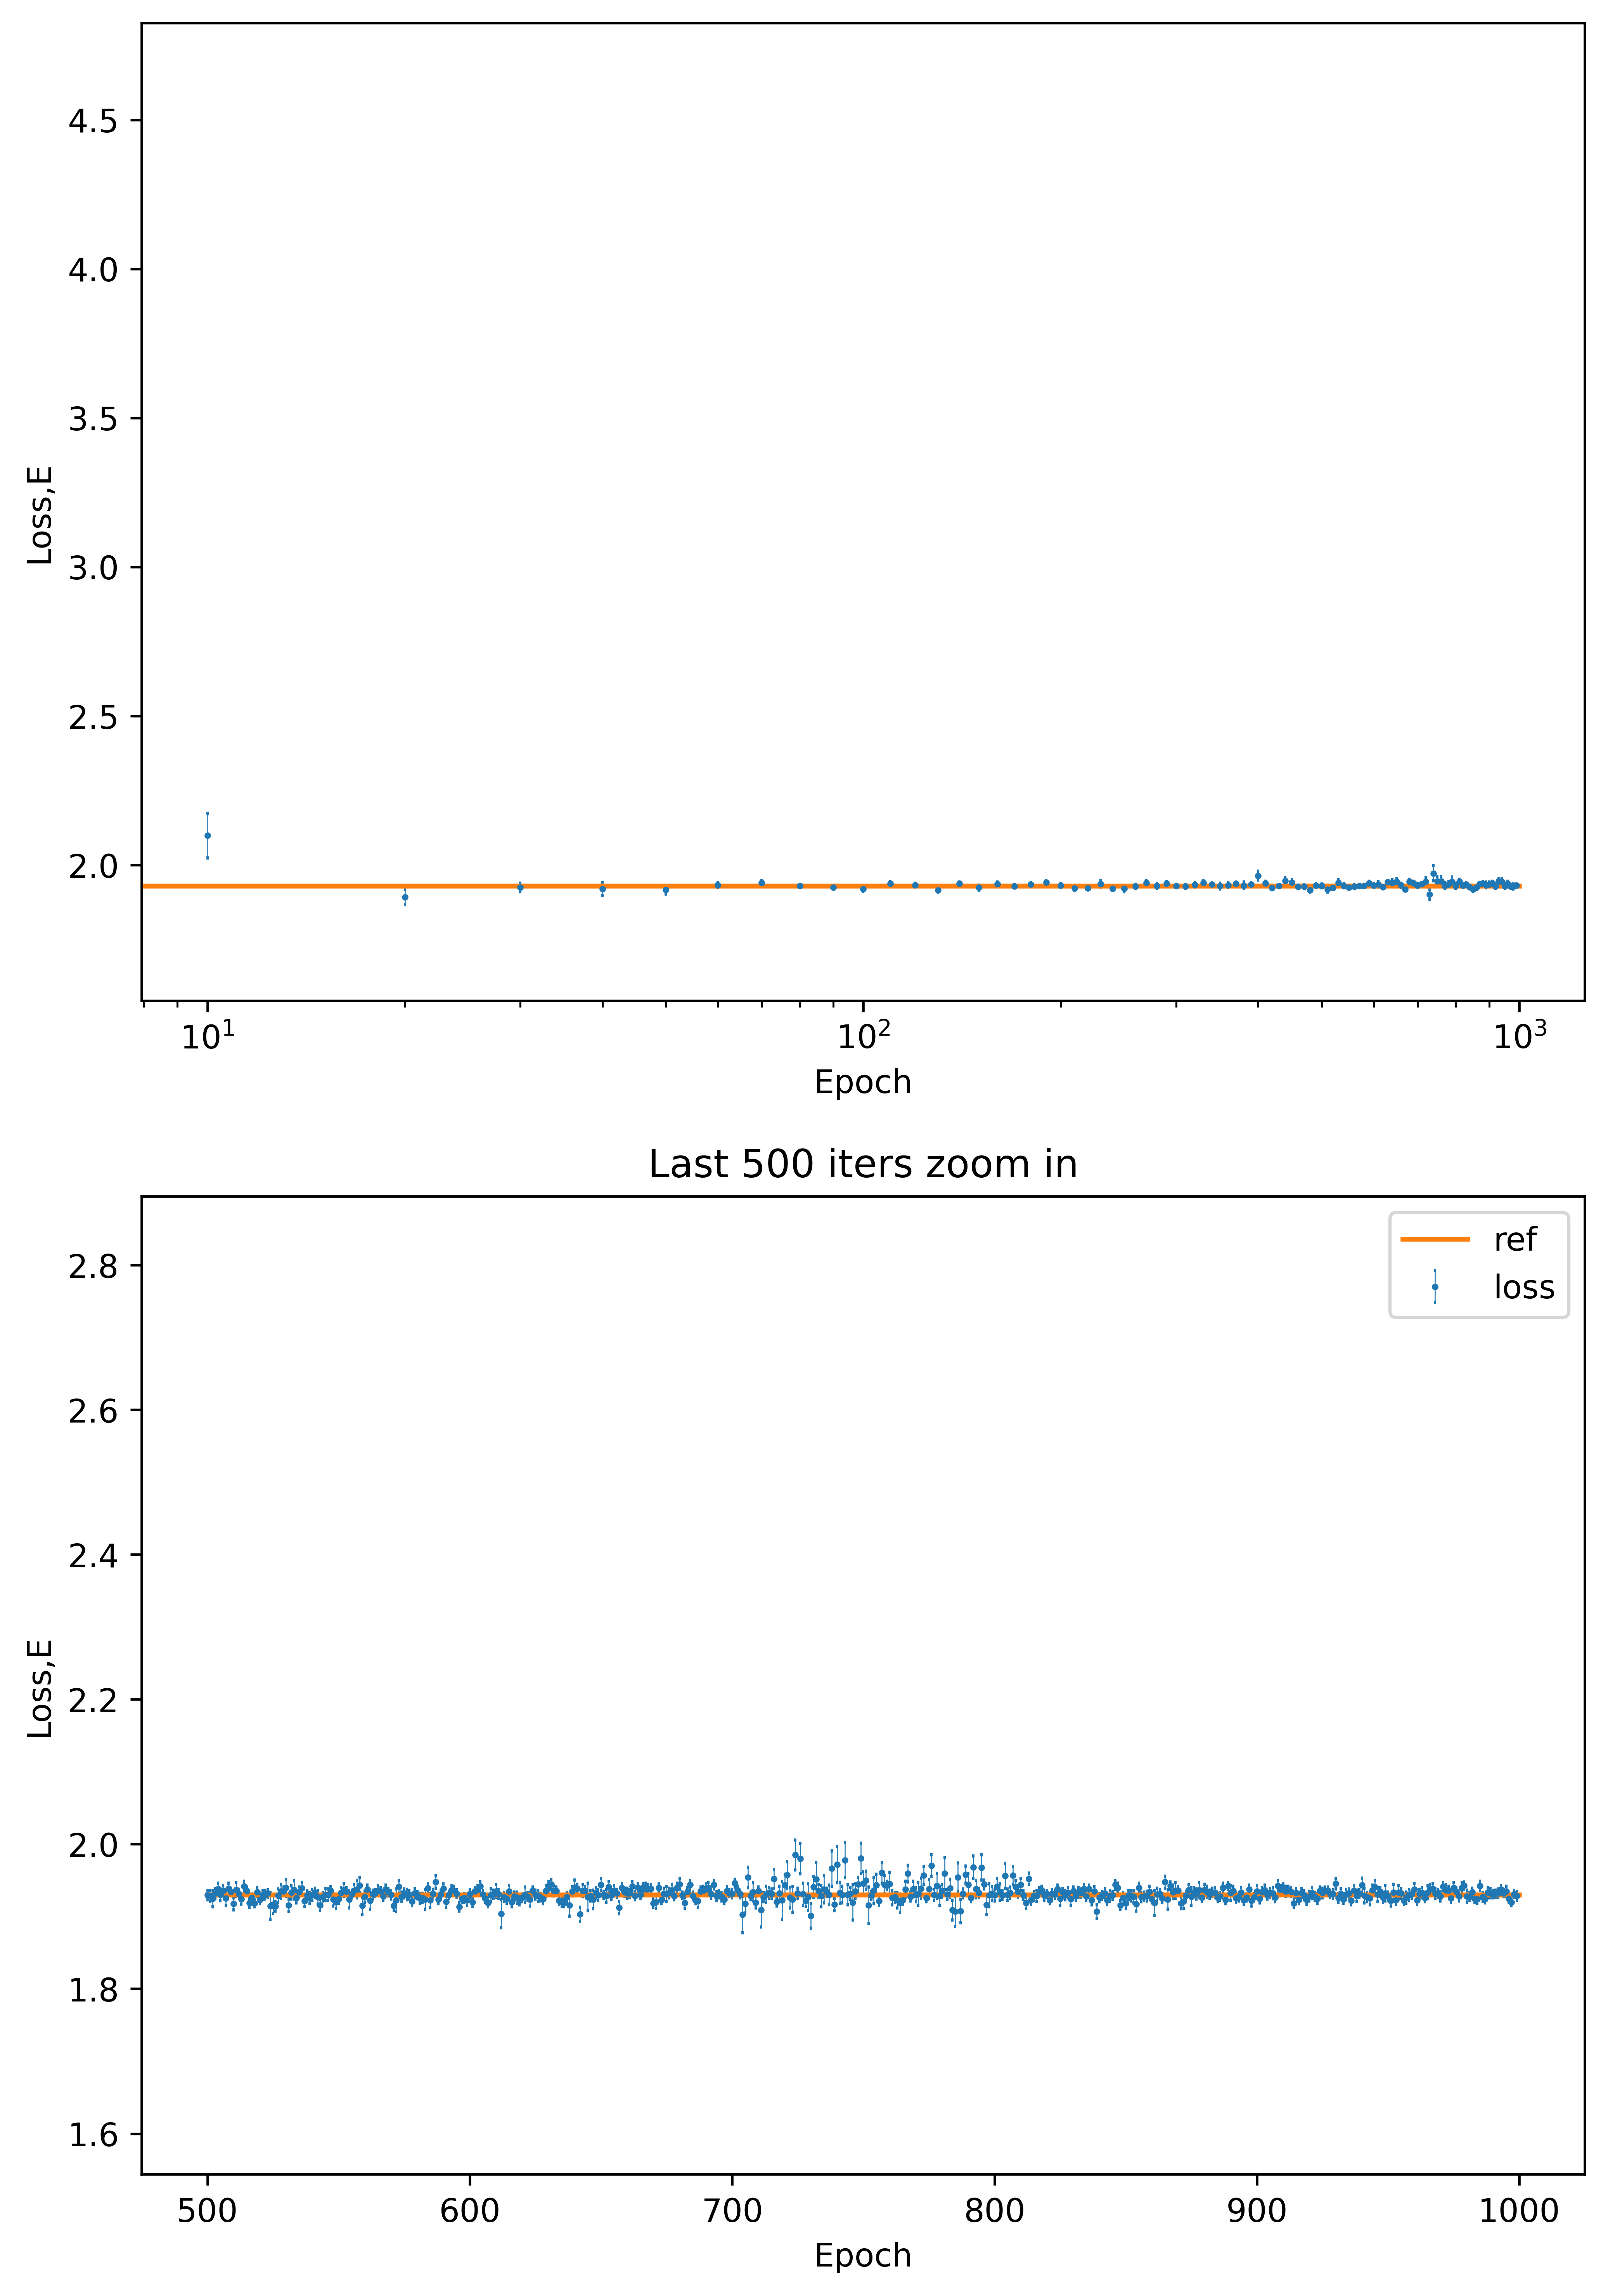

Plotting Potential


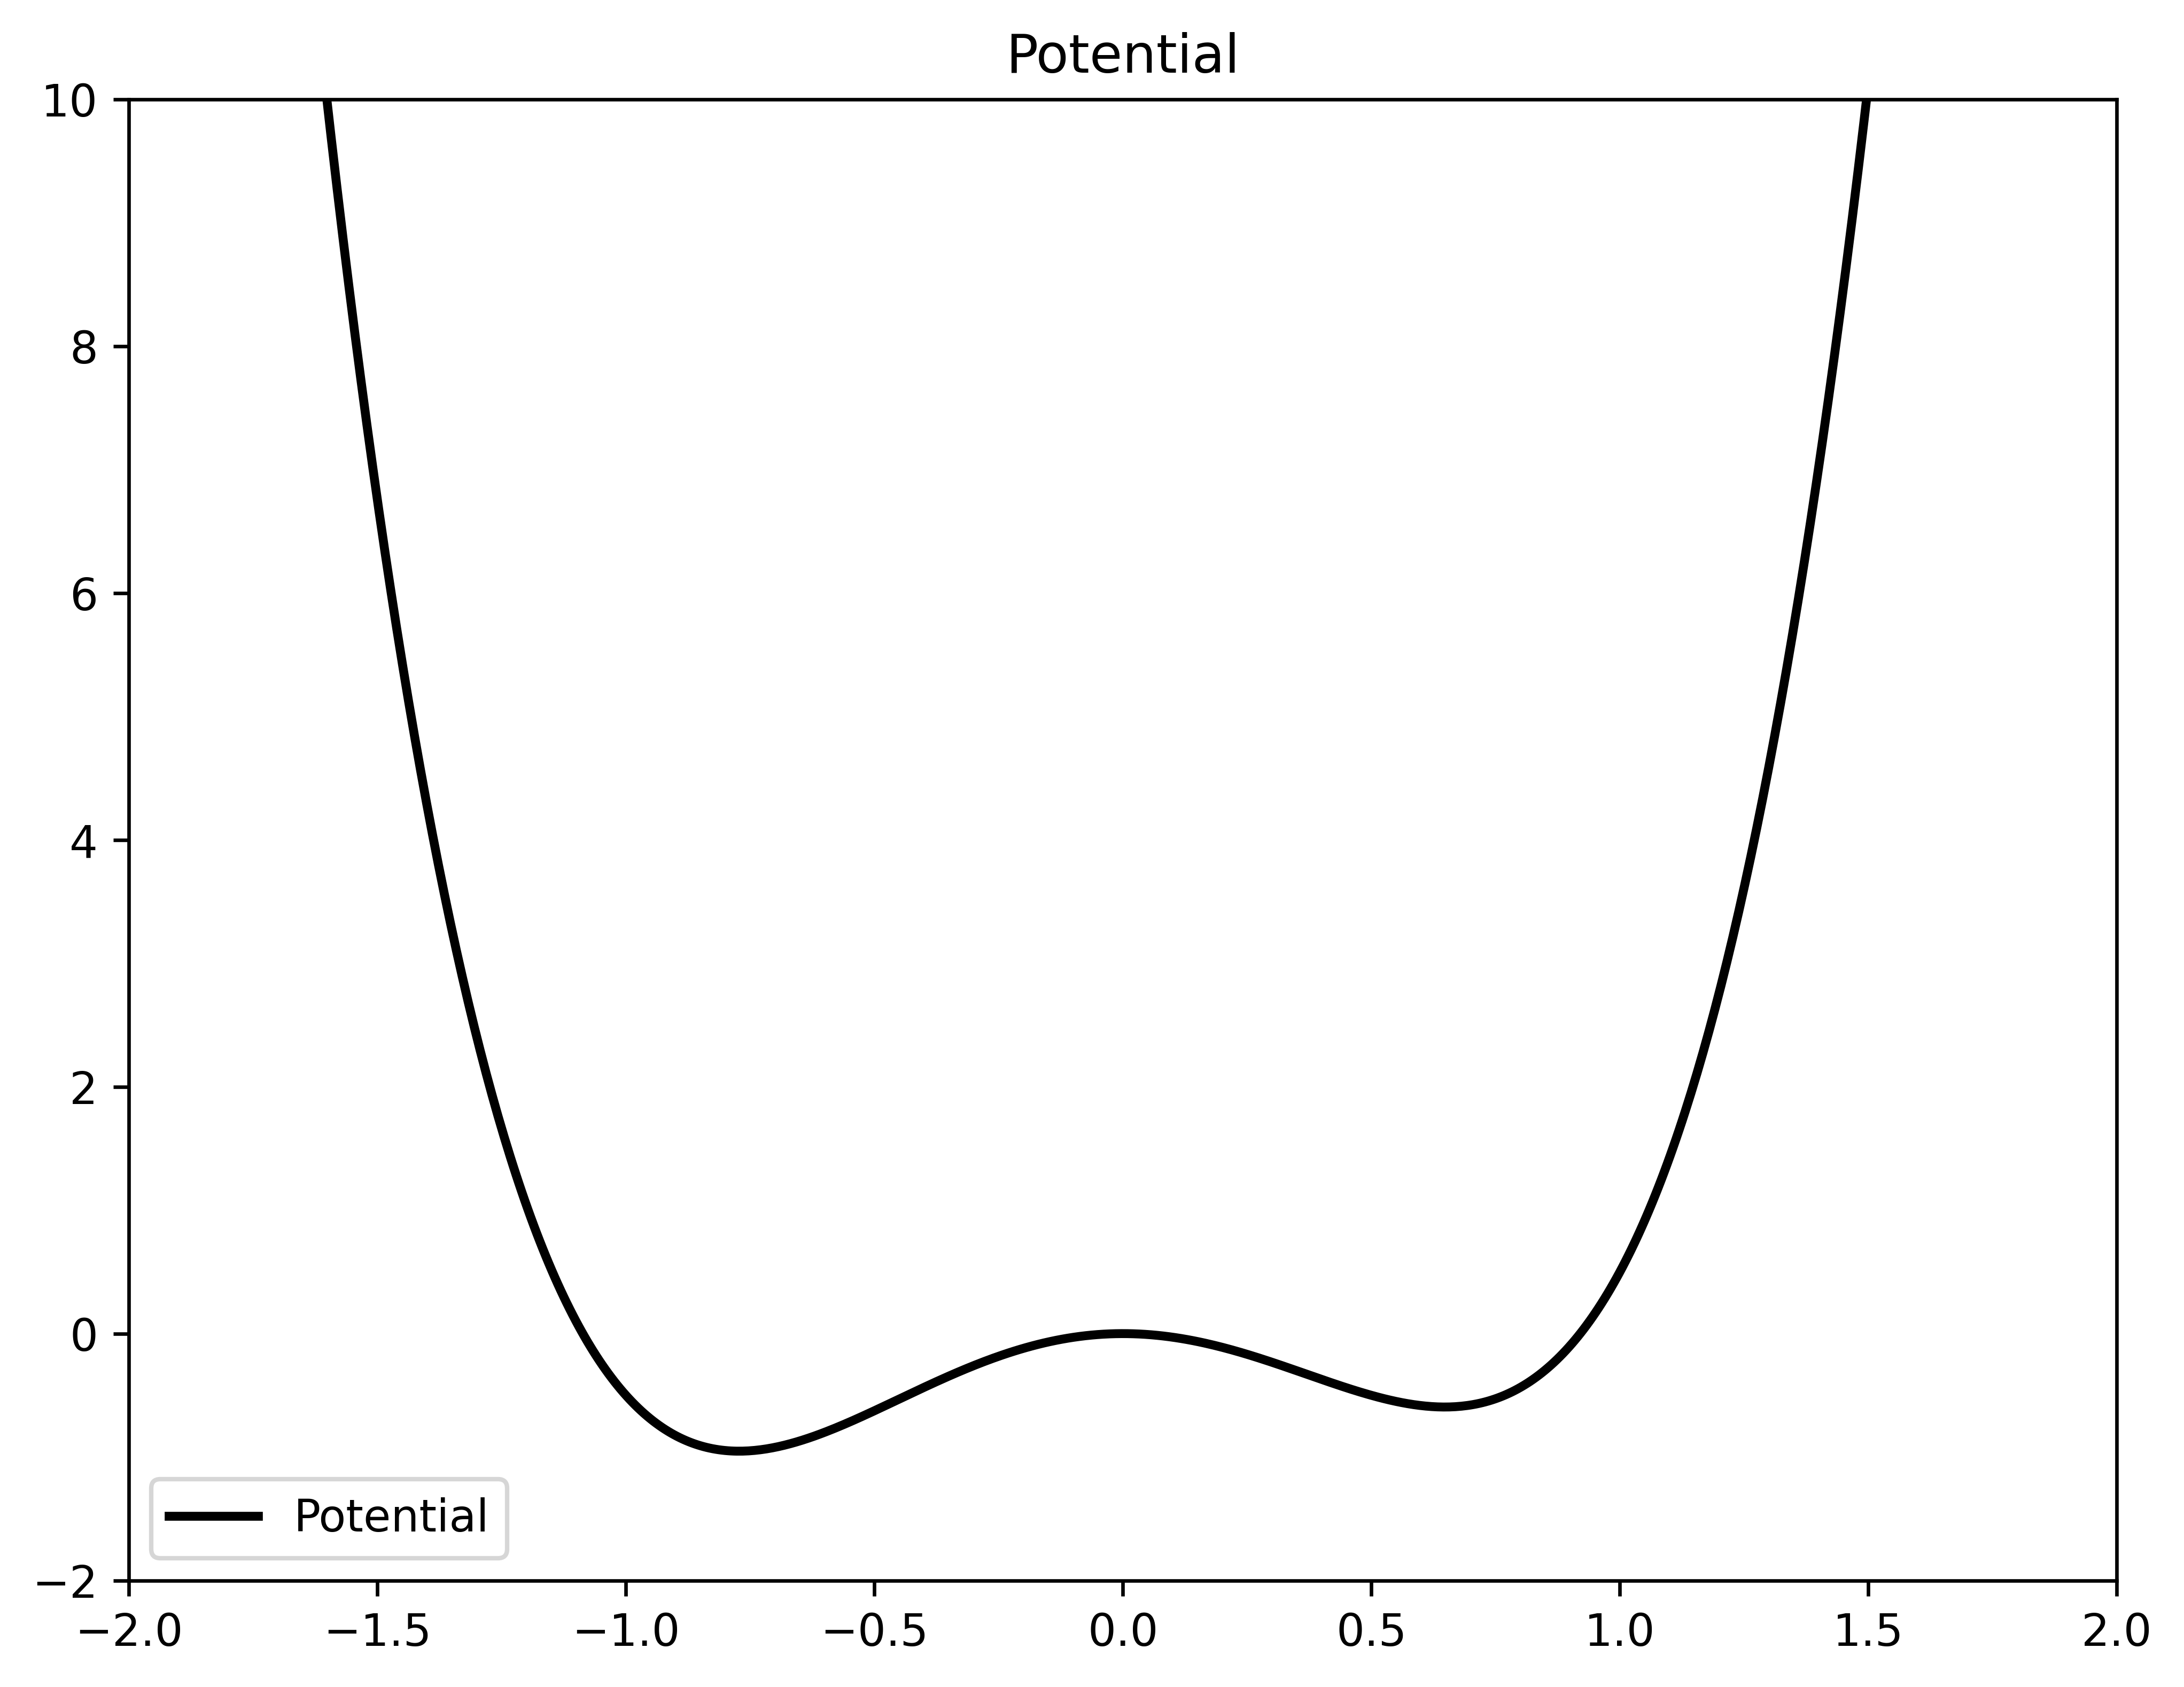

Probability Density (Trained)


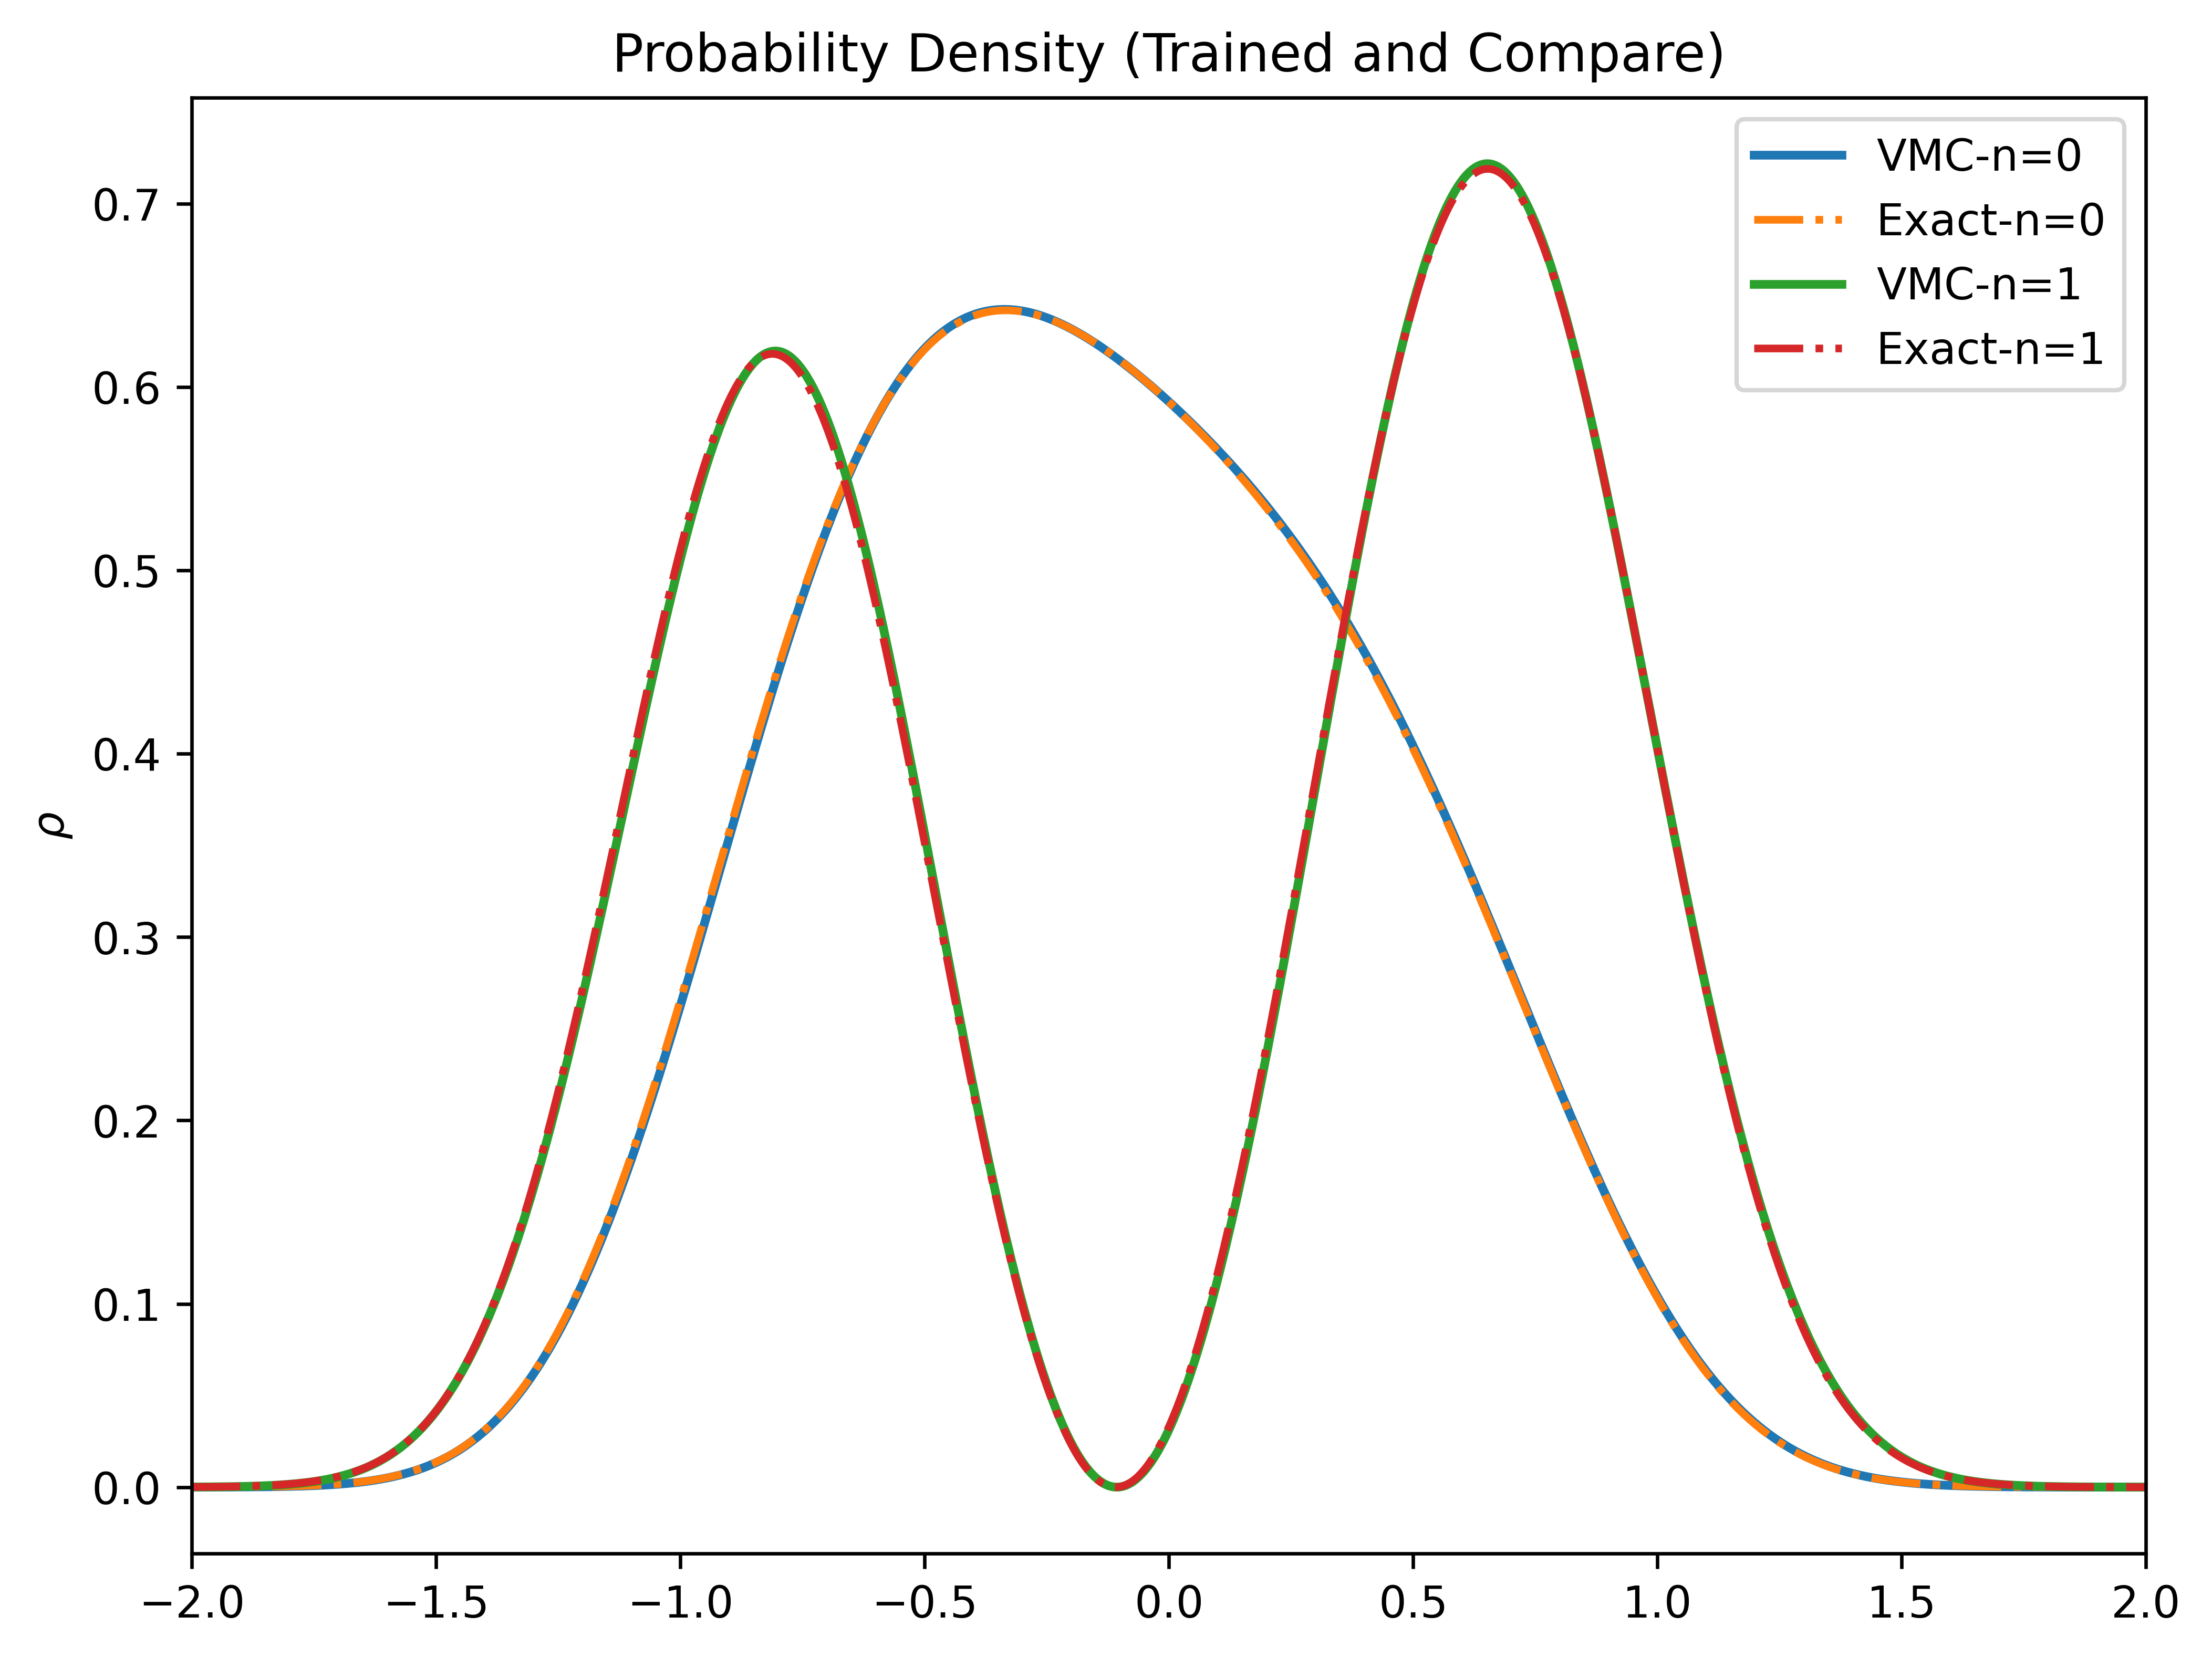

...Inferencing...
Thermalization...
After Thermalization:	pmove [0.850155 0.711355]	step_size=[0.3 0.3]	time=3.42s
Mesuring Energy...

VMC Result with [0 1] states:

n=0	energy=0.19348(0.00169)

n=1	energy=1.73478(0.00460)


Exact Result with [0 1] states:

n=0	energy=0.19458

n=1	energy=1.73520

Saving trained variables...
Done
Plotting z=f(x)...


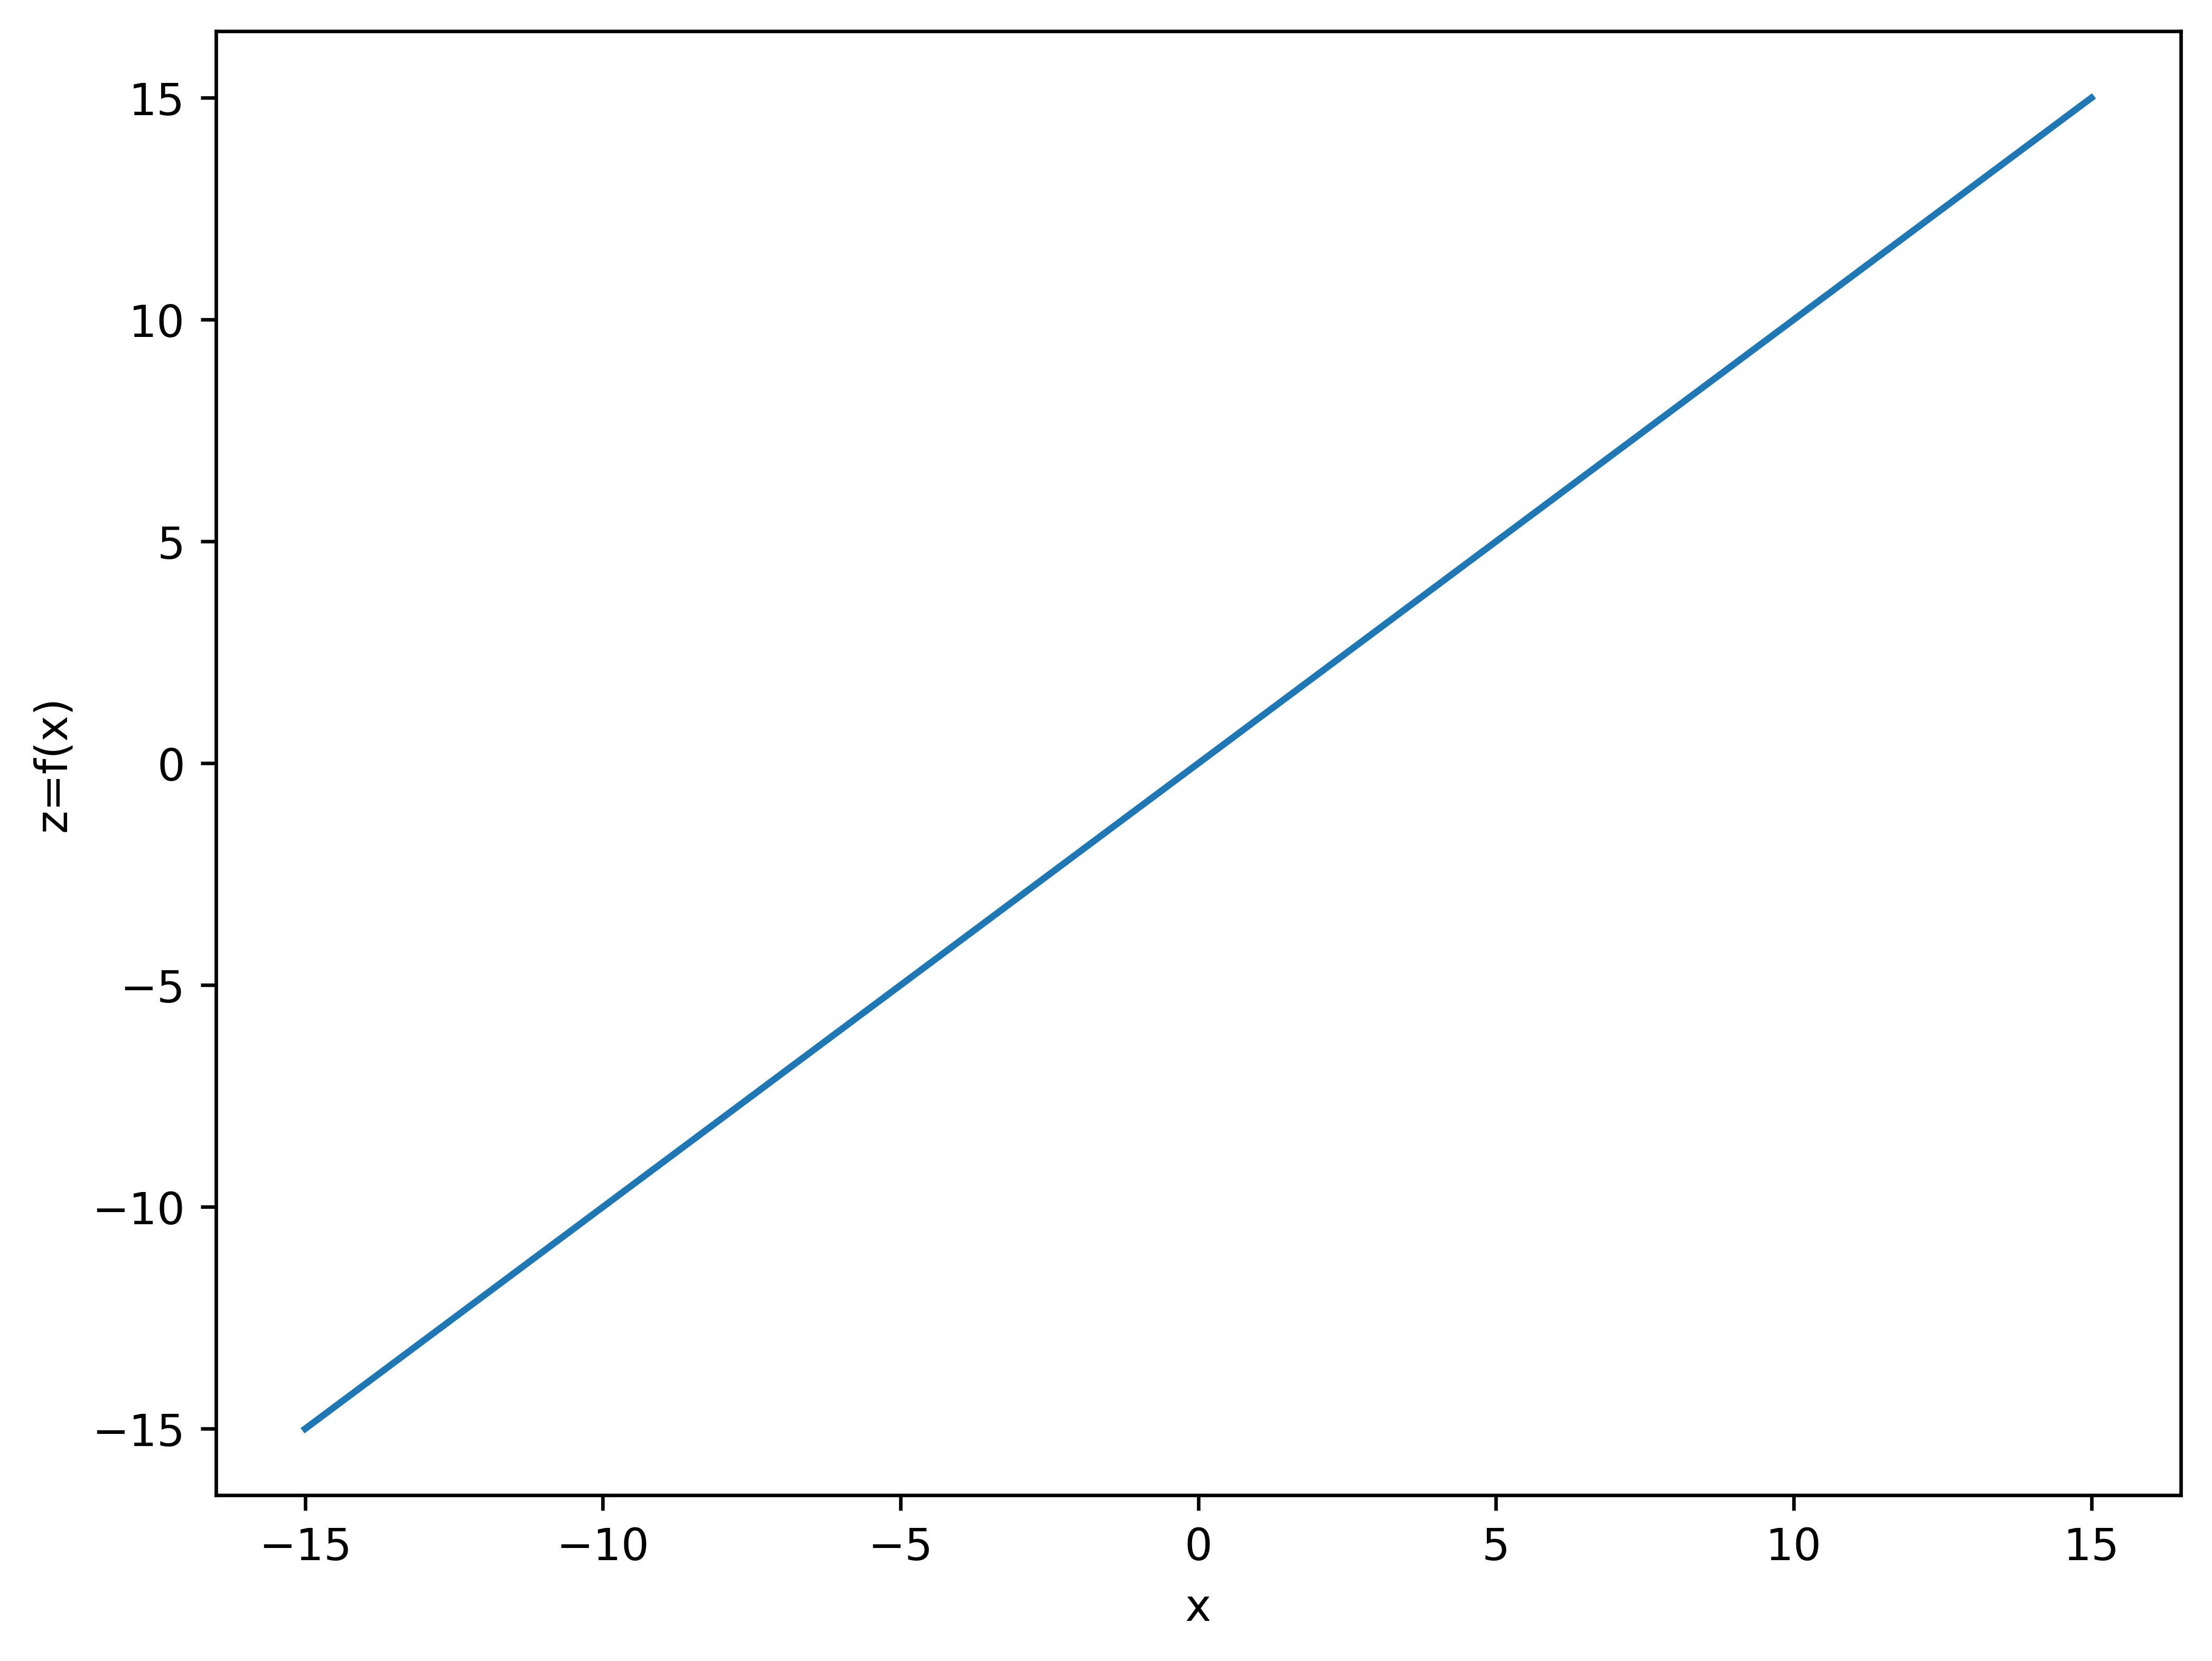

Figure saved.
Computed States Indices: [0 1]


In [1]:
import sys;sys.path.append("../")
import matplotlib.pyplot as plt
import jax

from VMC.utils import training_kernel

jax.config.update("jax_enable_x64", True)

# Plotting Settings
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 600

log_domain = False
ferminet_loss = False
clip_factor = None
wf_clip_factor = None
state_indices = [0,1]
ckpt_filename = None
vscf = True
nlevel = 30

total_num_of_states = len(state_indices)

if total_num_of_states <= 0:
    raise ValueError("Total Number of states must larger than 0!")
if not isinstance(total_num_of_states, int):
    raise TypeError("total number of states must be integer!")

if vscf:
    version = "VSCF"
else:
    version = "NoVSCF"

# Global System settings
batch_size = 200
mlp_width = 100
mlp_depth = 1
init_learning_rate = 5e-3
# NOTE: Sufficient MCMC Sampling
# is VITAL!
# For example, calculating 0,1
# The suggesting batch-mc_step-step_size combination is
# batch_size=200 with mc_step=1500 and step_size=0.3
mc_steps = 150
step_size = 0.3
thermal_step = 100
acc_steps = 1
init_width = 1.0
iterations = 1000
inference_thermal_step = 1000
params_init_width = {"kernel": 0.0005, "bias": 0.0}

figure_save_path = f"./figure/{version}/StateIndices{state_indices}/"

key = jax.random.PRNGKey(42)

# End of configuration
training_args = {
    "key": key,
    "batch_size": batch_size,
    "state_indices": state_indices,
    "thermal_step": thermal_step,
    "acc_steps": acc_steps,
    "mc_steps": mc_steps,
    "step_size": step_size,
    "init_width": init_width,
    "mlp_width": mlp_width,
    "mlp_depth": mlp_depth,
    "init_learning_rate": init_learning_rate,
    "iterations": iterations,
    "inference_thermal_step": inference_thermal_step,
    "figure_save_path": figure_save_path,
    "log_domain": log_domain,
    "ferminet_loss": ferminet_loss,
    "clip_factor": clip_factor,
    "wf_clip_factor": wf_clip_factor,
    "params_init_width": params_init_width,
    "ckpt_filename": ckpt_filename,
    "vscf": vscf,
    "nlevel": nlevel,
}

training_kernel(
    args=training_args,
    savefig=False
)